## the_comp_details

To understand the factors that lead a person to look for a job change, the agency wants you to design a model that uses the current credentials/demographics/experience to predict the probability of an enrollee to look for a new job.

**Data Dictionary**

**Variable Description**

- enrollee_id - Unique ID for enrollee
- city - City code
- city_development_index - Developement index of the city (scaled)
- gender - Gender
- relevent_experience - Relevent experience
- enrolled_university - Type of University course enrolled if any
- education_level - Education level
- major_discipline - Major discipline
- experience Total - experience in years
- company_size - No of employees in current employer's company
- company_type - Type of current employer
- last_new_job - Difference in years between previous job and current job
- training_hours - training hours completed
- target 0 – Not looking for job change, 1 – Looking for a job change

## imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import time
import xgboost as xgb
import lightgbm as lgb
import category_encoders as cat_ed
import gc, mlcrate, glob

from fastai.imports import *
from fastai.structured import *
from gplearn.genetic import SymbolicTransformer
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from IPython.display import display
from catboost import CatBoostClassifier
from scipy.cluster import hierarchy as hc
from collections import Counter

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# will ignore all warning from sklearn, seaborn etc..
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [3]:
PATH = os.getcwd();
PATH

'D:\\Github\\fastai\\courses\\ml1'

## read the datasets

In [11]:
df_raw = pd.read_csv(f'{PATH}\\AV_Stud_2\\train.csv', low_memory=False)
df_test = pd.read_csv(f'{PATH}\\AV_Stud_2\\test.csv', low_memory=False)

# STEM - Science, Technology, Engineering, Management

In [12]:
def display_all(df):
    with pd.option_context("display.max_rows", 100): 
        with pd.option_context("display.max_columns", 100): 
            display(df)

In [13]:
df_raw.shape, 

((18359, 14),)

In [14]:
df_raw.get_ftype_counts()

float64:dense     1
int64:dense       3
object:dense     10
dtype: int64

## initial processing

In [40]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('target', axis=1), df_raw.target)

ValueError: could not convert string to float: 'never'

**This dataset contains a mix of continuous and categorical variables.**

In [15]:
cols = ['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'enrolled_university_degree',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target']
df_raw.columns = cols
df_test.columns = cols[:-1]

In [18]:
train_cats(X_train_od);
apply_cats(X_test_od, X_train_od);

D:\Github\fastai\courses\ml1\fastai\structured.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [19]:
X_train_od.enrolled_university.cat.categories;
X_train_od.enrolled_university.cat.set_categories(['no_enrollment', 'Part time course', 'Full time course' ],\
                                    ordered=True, inplace=True)
X_train_od.enrolled_university = X_train_od.enrolled_university.cat.codes

X_train_od.enrolled_university_degree.cat.categories;
X_train_od.enrolled_university_degree.cat.set_categories(['Primary School','High School','Graduate', 'Masters', 'Phd',],\
                                    ordered=True, inplace=True)
X_train_od.enrolled_university_degree = X_train_od.enrolled_university_degree.cat.codes

X_train_od.relevent_experience.cat.set_categories(['No relevent experience','Has relevent experience'],\
                                    ordered=True, inplace=True)
X_train_od.relevent_experience = X_train_od.relevent_experience.cat.codes

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [20]:
X_test_od.enrolled_university.cat.categories;
X_test_od.enrolled_university.cat.set_categories(['no_enrollment', 'Part time course', 'Full time course' ],\
                                    ordered=True, inplace=True)
X_test_od.enrolled_university = X_test_od.enrolled_university.cat.codes

X_test_od.enrolled_university_degree.cat.categories;
X_test_od.enrolled_university_degree.cat.set_categories(['Primary School','High School','Graduate', 'Masters', 'Phd',],\
                                    ordered=True, inplace=True)
X_test_od.enrolled_university_degree = X_test_od.enrolled_university_degree.cat.codes

X_test_od.relevent_experience.cat.set_categories(['No relevent experience','Has relevent experience'],\
                                    ordered=True, inplace=True)
X_test_od.relevent_experience = X_test_od.relevent_experience.cat.codes

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [16]:
drop = ['enrollee_id']
df_raw.drop(drop, axis=1,inplace=True)
df_test.drop(drop, axis=1,inplace=True)

In [17]:
df_raw['enrolled_university_degree'].fillna(df_raw['enrolled_university_degree'].mode()[0],inplace=True)
df_raw['enrolled_university'].fillna(df_raw['enrolled_university'].mode()[0],inplace=True)

df_test['enrolled_university_degree'].fillna(df_test['enrolled_university_degree'].mode()[0],inplace=True)
df_test['enrolled_university'].fillna(df_test['enrolled_university'].mode()[0],inplace=True)

In [114]:
df, y, nas,  = proc_df(df_raw, 'target', max_n_cat=20,)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.2, random_state=42, stratify = y)

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 2000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((16359, 41), (16359,), (2000, 41))

## Baseline RF

In [70]:
def logloss(x,y): return metrics.log_loss(y_true = y, y_pred = x)

def print_score(m):
    
    print('Train Loss, Valid Loss, R**2 Train, R**2 Valid, OOB_Score(optional)')
    res = [logloss(m.predict_proba(X_train), y_train), logloss(m.predict_proba(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [68]:
m = RandomForestClassifier(n_estimators=20,n_jobs=-1, max_depth=5, max_features='auto')
m.fit(X_train, y_train)
print_score(m)

Train Loss, Valid Loss, R**2 Train, R**2 Valid, OOB_Score(optional)
[0.36985482373263973, 0.36430670428351336, 0.86710679136866553, 0.87450000000000006]


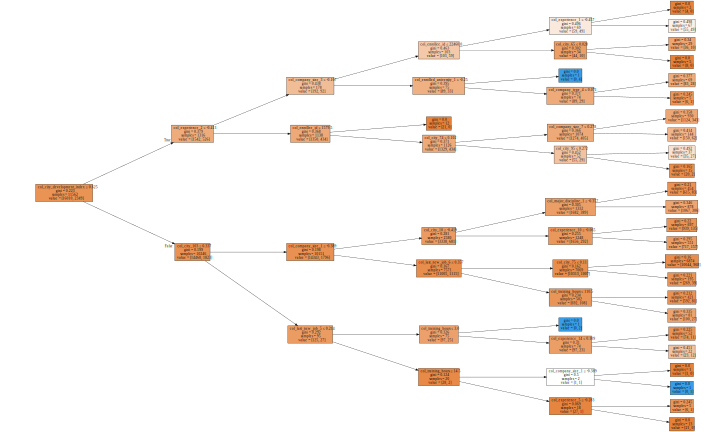

In [77]:
draw_tree(m.estimators_[0], df, precision=3)

In [73]:
m = RandomForestClassifier(n_estimators=10, n_jobs=-1, oob_score=True, max_depth=5)
m.fit(X_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Train Loss, Valid Loss, R**2 Train, R**2 Valid, OOB_Score(optional)
[0.36979450404333986, 0.36537382401608476, 0.86710679136866553, 0.87450000000000006, 0.86692340607616603]


In [74]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=3,max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train Loss, Valid Loss, R**2 Train, R**2 Valid, OOB_Score(optional)
[0.20387255010799227, 0.38711766787524177, 0.89974937343358397, 0.87350000000000005, 0.86484503942783786]


In [75]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
6,training_hours,0.257144
5,experience,0.149266
1,city_development_index,0.118949
0,city,0.094909
4,enrolled_university_degree,0.038956
3,enrolled_university,0.031631
34,last_new_job_1,0.025014
8,gender_Male,0.019788
2,relevent_experience,0.019407
10,gender_nan,0.017197


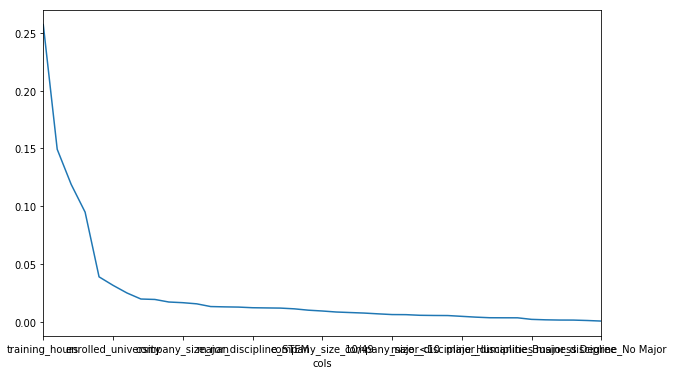

In [76]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [77]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

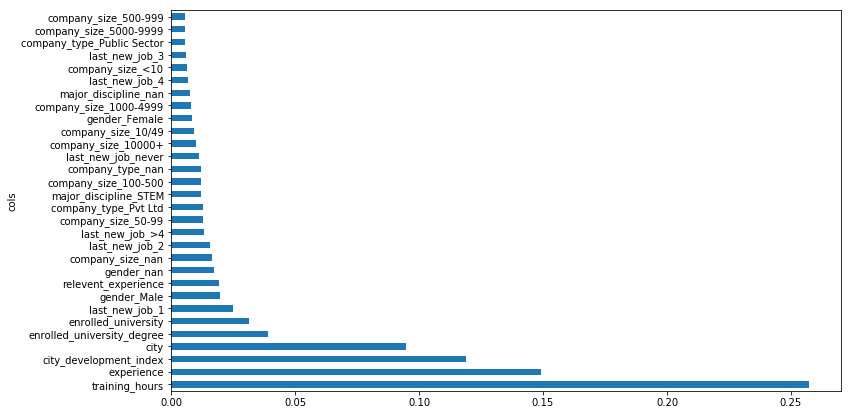

In [78]:
plot_fi(fi[:30]);

In [85]:
to_keep = fi[fi.imp>0.002].cols; len(to_keep)

42

In [87]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [97]:
m = RandomForestRegressor(n_estimators=200, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train Loss, Valid Loss, R**2 Train, R**2 Valid
[0.094103076588840262, 0.38694119197589372, 0.86124718844888137, -0.026665415171825746, -0.013963884820979544]


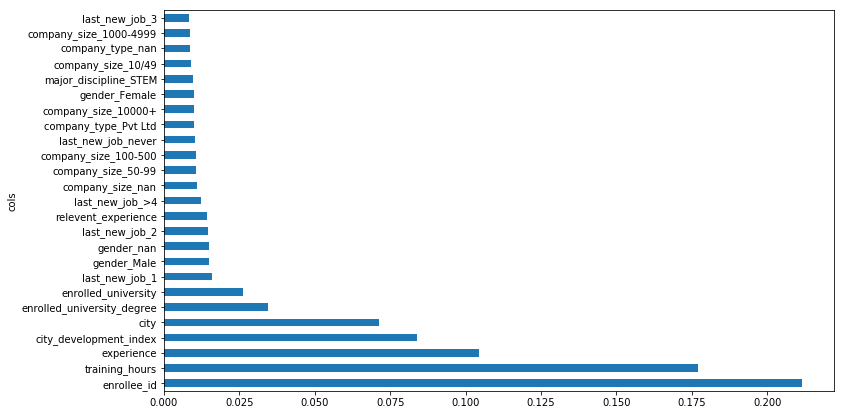

In [91]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:25]);

In [92]:
from scipy.cluster import hierarchy as hc

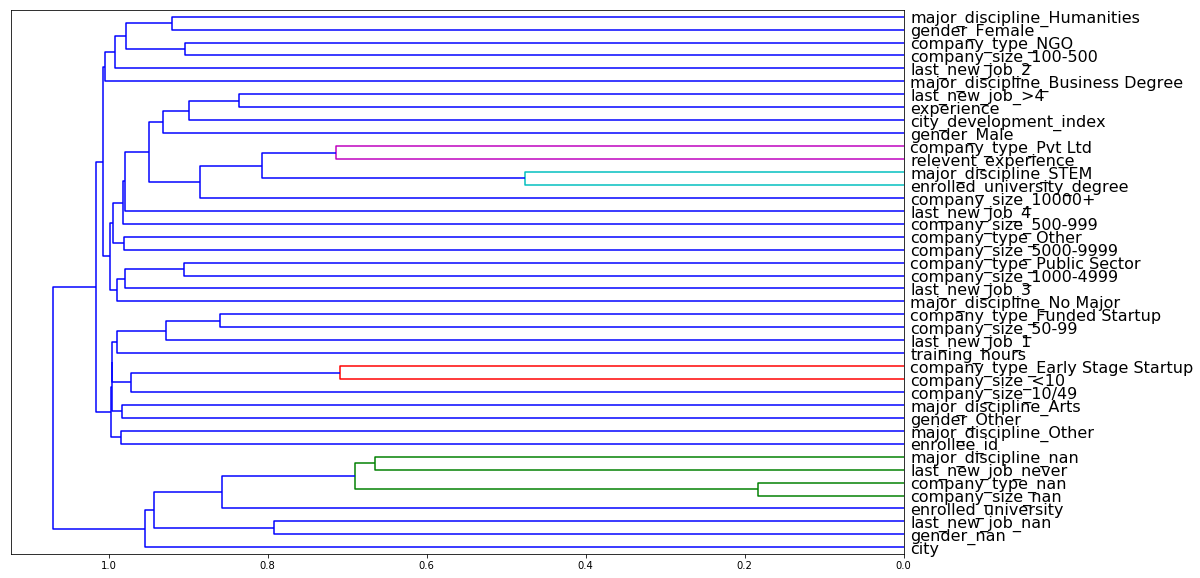

In [93]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [94]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=200, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

## preds

In [79]:
m

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [118]:
m = RandomForestClassifier(n_estimators=200, min_samples_leaf=3,max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df, y)
print_score(m)

Train Loss, Valid Loss, R**2 Train, R**2 Valid, OOB_Score(optional)
[0.20420249978426797, 0.2008521456131836, 0.89730423620025679, 0.89949999999999997, 0.86507979737458462]


In [119]:
df_test['target'] = y[:df_test.shape[0]]
df_test_, _, _ = proc_df(df_test, 'target', na_dict=nas, max_n_cat=20)

In [120]:
set(df.columns) - set(df_test_.columns)

set()

In [121]:
set(df_test_.columns) - set(df.columns)

set()

In [122]:
preds = m.predict_proba(df_test_)

In [49]:
def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\AV_Stud_2\\sample_submission.csv')
    submit = sample.copy()
    submit['target'] = probs
    return submit

In [112]:
submit = make_submission(preds)
submit.to_csv(f'{PATH}\\AV_Stud_2\\rf.csv', index=False)
submit.head(2)

,enrollee_id,target
0,16548,0.815661
1,12036,0.027220


## 9th July

In [17]:
#drop id if original data is imported
target = df_raw.target.values
df_raw.drop(['target'],axis=1, inplace=True)
#df_test.drop('id', axis=1, inplace=True)

features = df_raw.columns
numeric_features = []
categorical_features = []
i = 0
index = []
for dtype, feature in zip(df_raw.dtypes, df_raw.columns):

    if dtype == object:
        #print(column)
        #print(train_data[column].describe())
        categorical_features.append(feature)
        index.append(i)
    else:
        numeric_features.append(feature)
    i +=1
categorical_features;

train_cats(df_raw);
apply_cats(df_test, df_raw)

X_train_num = df_raw.drop(categorical_features,axis=1)  #numeric ones
X_test_num  = df_test.drop(categorical_features,axis=1) #numeric ones

X_train_od = df_raw[categorical_features]  #numeric ones
X_test_od  = df_test[categorical_features] #numeric ones

In [69]:
import category_encoders as cat_ed

In [70]:
encoder = cat_ed.backward_difference.BackwardDifferenceEncoder(drop_invariant=True,cols=categorical_features)

df_raw = encoder.fit_transform(df_raw, verbose=1)
df_test = encoder.transform(df_test)

In [71]:
df_raw.shape, df_test.shape

((18359, 183), (15021, 183))

In [51]:
def Intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

In [70]:
model=CatBoostClassifier(iterations=1020, depth=8, learning_rate=0.06, loss_function= 'Logloss')
model.fit(X_stack_train, target)

0:	learn: 0.6503847	total: 282ms	remaining: 4m 47s
1:	learn: 0.6129987	total: 351ms	remaining: 2m 58s
2:	learn: 0.5796037	total: 421ms	remaining: 2m 22s
3:	learn: 0.5514890	total: 485ms	remaining: 2m 3s
4:	learn: 0.5270214	total: 552ms	remaining: 1m 52s
5:	learn: 0.5064879	total: 618ms	remaining: 1m 44s
6:	learn: 0.4889237	total: 685ms	remaining: 1m 39s
7:	learn: 0.4731387	total: 749ms	remaining: 1m 34s
8:	learn: 0.4591367	total: 825ms	remaining: 1m 32s
9:	learn: 0.4473548	total: 894ms	remaining: 1m 30s
10:	learn: 0.4366933	total: 961ms	remaining: 1m 28s
11:	learn: 0.4274822	total: 1.03s	remaining: 1m 26s
12:	learn: 0.4196324	total: 1.09s	remaining: 1m 24s
13:	learn: 0.4130140	total: 1.15s	remaining: 1m 22s
14:	learn: 0.4067396	total: 1.22s	remaining: 1m 21s
15:	learn: 0.4013903	total: 1.28s	remaining: 1m 20s
16:	learn: 0.3965975	total: 1.35s	remaining: 1m 19s
17:	learn: 0.3923884	total: 1.41s	remaining: 1m 18s
18:	learn: 0.3893522	total: 1.48s	remaining: 1m 17s
19:	learn: 0.3860844	to

KeyboardInterrupt: 

In [89]:
preds = model.predict_proba(df_test)[:,1]

In [91]:
m = RandomForestClassifier(n_estimators=200,n_jobs=-1, max_features='auto')
m.fit(df_raw, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
fi = rf_feat_importance(m, df_raw); fi[:10]

,cols,imp
182,col_training_hours,0.216338
181,col_city_development_index,0.051304
121,col_gender_1,0.030305
129,col_enrolled_university_degree_2,0.027899
176,col_last_new_job_2,0.026573
124,col_relevent_experience_1,0.023331
126,col_enrolled_university_2,0.023020
177,col_last_new_job_3,0.018803
178,col_last_new_job_4,0.017770
169,col_company_type_1,0.015755


In [97]:
preds = m.predict_proba(df_test)[:,1]

In [108]:
X_train['target'] = target

In [106]:
X_train['city_development_index'].value_counts().sort_values(ascending=False).head(20)

0.920    5185
0.624    1672
0.910    1654
0.926    1472
0.698     655
0.897     624
0.939     544
0.855     455
0.924     318
0.804     313
0.884     281
0.887     271
0.754     264
0.913     217
0.899     194
0.802     188
0.925     178
0.893     175
0.878     156
0.743     152
Name: city_development_index, dtype: int64

In [113]:
X_train.columns

Index(['enrollee_id', 'city_development_index', 'training_hours', 'target'], dtype='object')

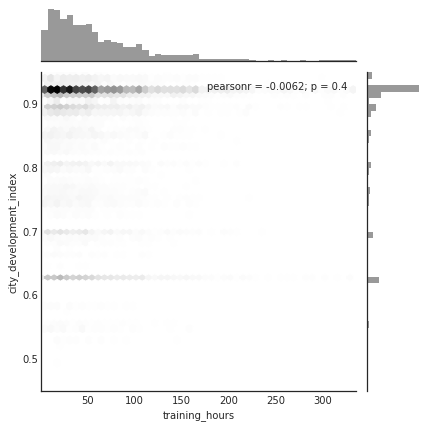

In [116]:
with sns.axes_style("white"):
    sns.jointplot(x='training_hours', y='city_development_index',data=X_train, kind="hex", color='k');

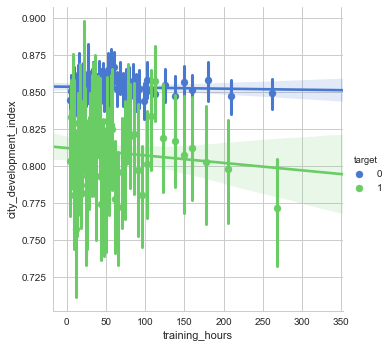

In [142]:
sns.lmplot('training_hours','city_development_index', X_train, 'target', x_bins= 50)

In [147]:
X_test.columns, X_train.columns

(Index(['city_development_index', 'training_hours'], dtype='object'),
 Index(['city_development_index', 'training_hours', 'target'], dtype='object'))

In [155]:
preds = X_test.training_hours.map(X_train.groupby('training_hours')['target'].mean())

In [156]:
preds

0        0.101852
1        0.120690
2        0.118367
3        0.115385
4        0.118421
5        0.150000
6        0.147982
7        0.081818
8        0.075758
9        0.142857
10       0.123404
11       0.107345
12       0.206897
13       0.177778
14       0.120833
15       0.166667
16       0.129825
17       0.138996
18       0.118143
19       0.123404
20       0.119048
21       0.131868
22       0.103093
23       0.113043
24       0.000000
25       0.092896
26       0.076923
27       0.117318
28       0.159091
29       0.109091
           ...   
14991    0.108108
14992    0.166667
14993    0.149194
14994    0.428571
14995    0.120833
14996    0.139665
14997    0.160494
14998    0.153846
14999    0.104348
15000    0.131579
15001    0.131868
15002    0.125000
15003    0.152344
15004    0.171429
15005    0.092593
15006    0.169231
15007    0.134831
15008    0.129825
15009    0.123404
15010    0.088889
15011    0.155340
15012    0.081818
15013    0.095238
15014    0.152344
15015    0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


ValueError: posx and posy should be finite values

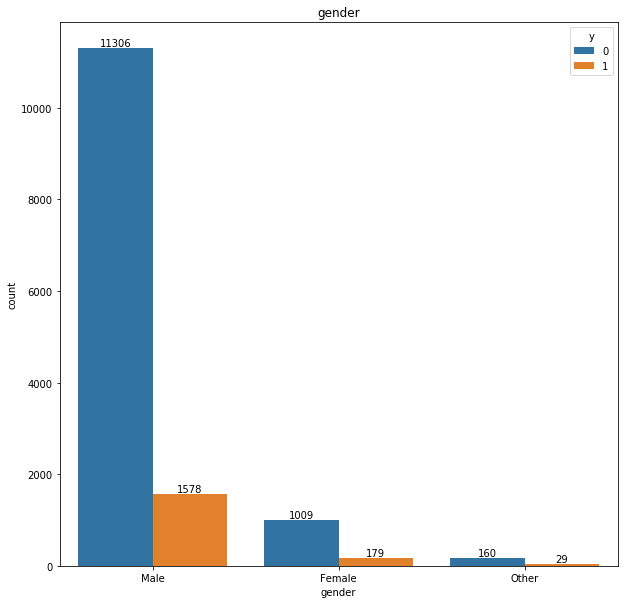

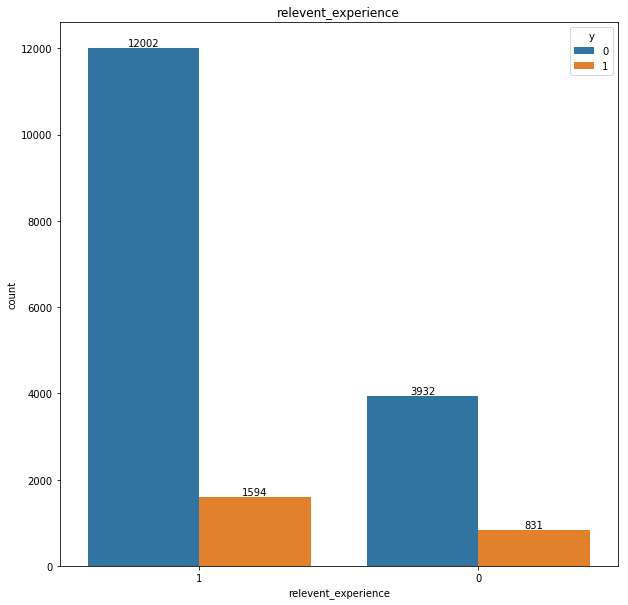

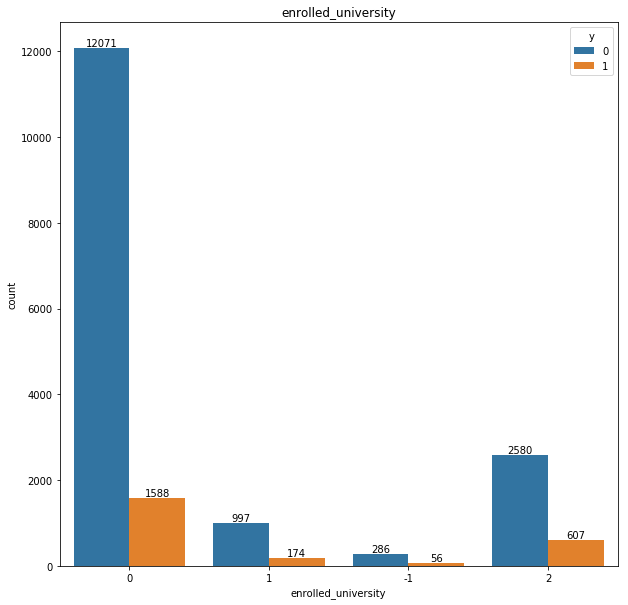

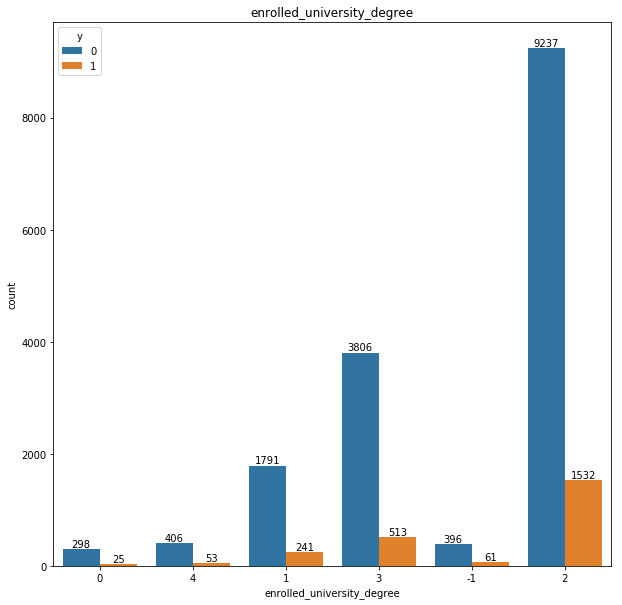

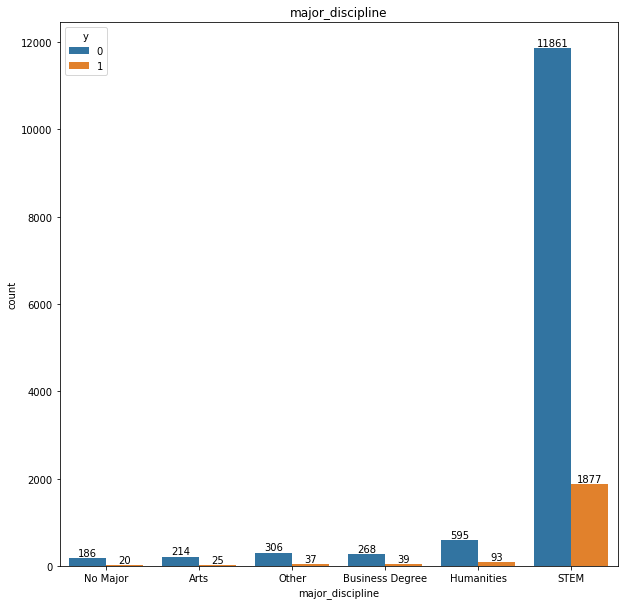

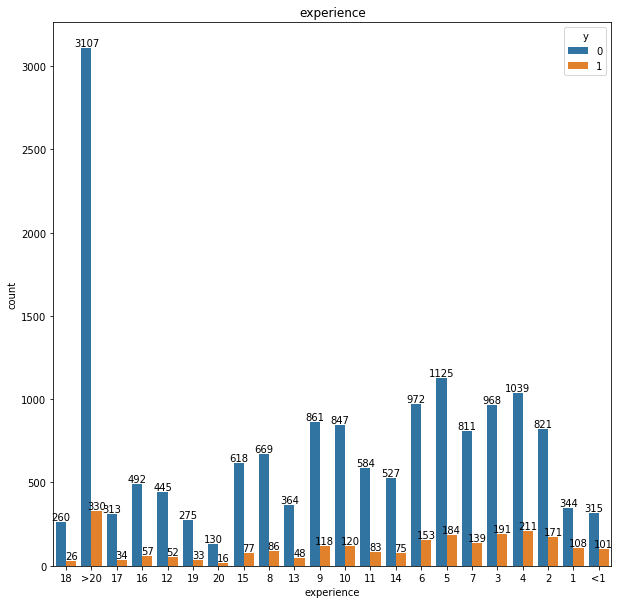

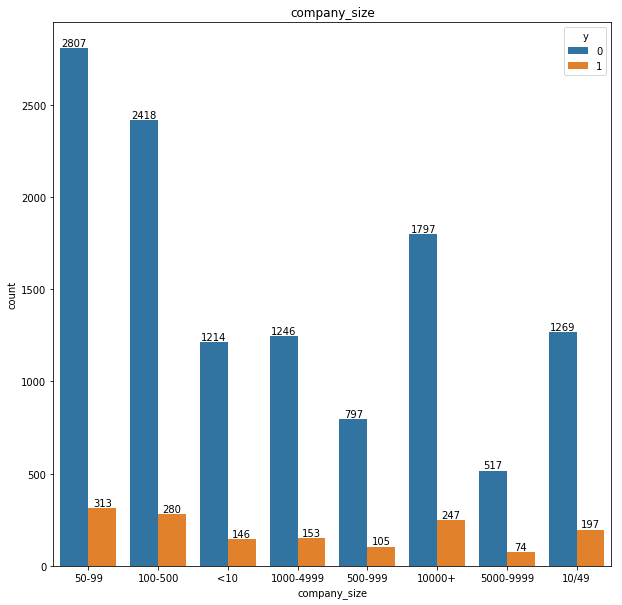

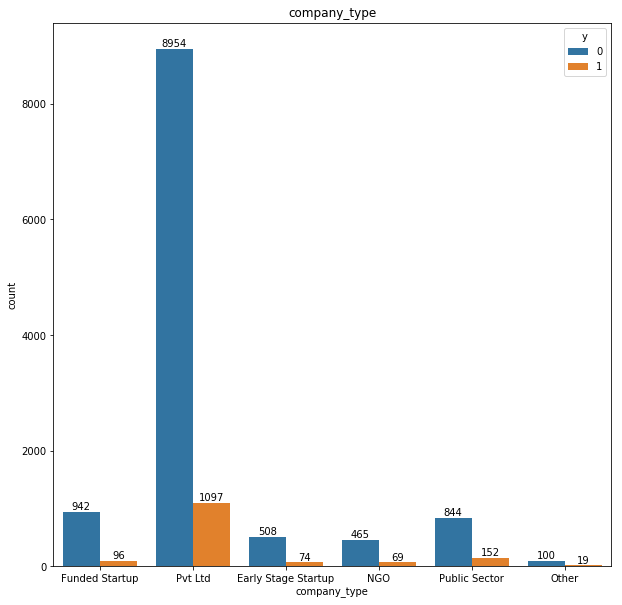

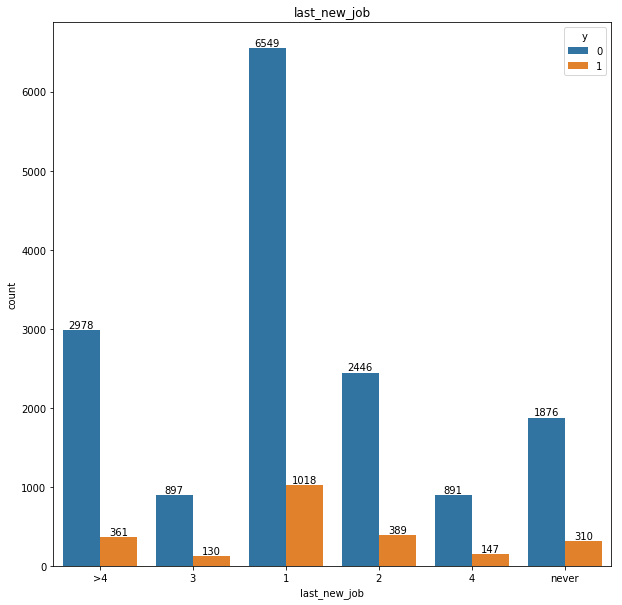

In [57]:
X_train_od['y'] = target
# plt.figure(figsize=(30,32))
for i in range(len(categorical_features)):
    
    plt.figure(figsize=(10,10))
    c = categorical_features[i]
    
    means = X_train_od.groupby(c).y.mean()
    stds = X_train_od.groupby(c).y.std().fillna(0)
    maxs = X_train_od.groupby(c).y.max()
    mins = X_train_od.groupby(c).y.min()
    
    ddd = pd.concat([means, stds, maxs, mins], axis=1); 
    ddd.columns = ['means', 'stds', 'maxs', 'mins']
    ddd.sort_values('means', inplace=True)
    

    ax = sns.countplot(x=c, order=ddd.index.values,data=X_train_od, hue='y')
    plt.title(c)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.0f}'.format(y), (x.mean(), y), ha='center', va='bottom')

In [64]:
# This way we have randomness and are able to reproduce the behaviour within this cell.
np.random.seed(13)

def impact_coding(data, feature, target='y'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    '''
    n_folds = 7
    n_inner_folds = 5
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                                      if x[feature] in oof_mean.index
                                      else oof_default_inner_mean
                            , axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                                      if x[feature] in inner_oof_mean_cv.index
                                      else oof_default_mean
                            , axis=1))

    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

# Apply the encoding to training and test data, and preserve the mapping

X_train_od['y'] = target
impact_coding_map = {}
for f in categorical_features:
    print("Impact coding for {}".format(f))
    X_train_od["impact_encoded_{}".format(f)], impact_coding_mapping, default_coding = impact_coding(X_train_od, f)
    impact_coding_map[f] = (impact_coding_mapping, default_coding)
    mapping, default_mean = impact_coding_map[f]
    X_test_od["impact_encoded_{}".format(f)] = X_test_od.apply(lambda x: mapping[x[f]]
                                                                         if x[f] in mapping
                                                                         else default_mean
                                                               , axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Impact coding for city


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Impact coding for gender
Impact coding for relevent_experience
Impact coding for enrolled_university
Impact coding for enrolled_university_degree
Impact coding for major_discipline
Impact coding for experience
Impact coding for company_size
Impact coding for company_type
Impact coding for last_new_job


In [67]:
X_train_od.drop(categorical_features, axis=1, inplace=True)
X_test_od.drop(categorical_features, axis=1, inplace=True)
X_train_od.drop('y', axis=1, inplace=True)

In [104]:
X_stack_train, X_stack_test = np.hstack((X_train_num, X_train_od)), np.hstack((X_test_num, X_test_od))

In [105]:
model=CatBoostClassifier(iterations=1024, depth=8, learning_rate=0.06, loss_function= 'Logloss')
model.fit(X_stack_train, target)

0:	learn: 0.6487793	total: 70.1ms	remaining: 1m 11s
1:	learn: 0.6110423	total: 141ms	remaining: 1m 12s
2:	learn: 0.5787638	total: 210ms	remaining: 1m 11s
3:	learn: 0.5510888	total: 282ms	remaining: 1m 11s
4:	learn: 0.5272061	total: 333ms	remaining: 1m 7s
5:	learn: 0.5057416	total: 404ms	remaining: 1m 8s
6:	learn: 0.4886206	total: 474ms	remaining: 1m 8s
7:	learn: 0.4717282	total: 555ms	remaining: 1m 10s
8:	learn: 0.4589159	total: 614ms	remaining: 1m 9s
9:	learn: 0.4468200	total: 686ms	remaining: 1m 9s
10:	learn: 0.4364113	total: 754ms	remaining: 1m 9s
11:	learn: 0.4280056	total: 936ms	remaining: 1m 18s
12:	learn: 0.4197143	total: 1.01s	remaining: 1m 18s
13:	learn: 0.4122720	total: 1.08s	remaining: 1m 18s
14:	learn: 0.4065293	total: 1.16s	remaining: 1m 17s
15:	learn: 0.4017786	total: 1.23s	remaining: 1m 17s
16:	learn: 0.3975269	total: 1.3s	remaining: 1m 16s
17:	learn: 0.3932339	total: 1.37s	remaining: 1m 16s
18:	learn: 0.3895112	total: 1.45s	remaining: 1m 16s
19:	learn: 0.3861101	total: 

159:	learn: 0.3205510	total: 11.6s	remaining: 1m 2s
160:	learn: 0.3203034	total: 11.6s	remaining: 1m 2s
161:	learn: 0.3199514	total: 11.7s	remaining: 1m 2s
162:	learn: 0.3197771	total: 11.8s	remaining: 1m 2s
163:	learn: 0.3196553	total: 11.8s	remaining: 1m 2s
164:	learn: 0.3194160	total: 11.9s	remaining: 1m 1s
165:	learn: 0.3191698	total: 11.9s	remaining: 1m 1s
166:	learn: 0.3188390	total: 12s	remaining: 1m 1s
167:	learn: 0.3185741	total: 12.1s	remaining: 1m 1s
168:	learn: 0.3181568	total: 12.2s	remaining: 1m 1s
169:	learn: 0.3178827	total: 12.2s	remaining: 1m 1s
170:	learn: 0.3176774	total: 12.3s	remaining: 1m 1s
171:	learn: 0.3175355	total: 12.4s	remaining: 1m 1s
172:	learn: 0.3175343	total: 12.4s	remaining: 1m 1s
173:	learn: 0.3172387	total: 12.5s	remaining: 1m
174:	learn: 0.3169713	total: 12.5s	remaining: 1m
175:	learn: 0.3167101	total: 12.6s	remaining: 1m
176:	learn: 0.3164490	total: 12.7s	remaining: 1m
177:	learn: 0.3161657	total: 12.7s	remaining: 1m
178:	learn: 0.3159494	total: 

319:	learn: 0.2850246	total: 22.2s	remaining: 48.8s
320:	learn: 0.2848713	total: 22.3s	remaining: 48.7s
321:	learn: 0.2846386	total: 22.3s	remaining: 48.7s
322:	learn: 0.2845065	total: 22.4s	remaining: 48.6s
323:	learn: 0.2843691	total: 22.5s	remaining: 48.5s
324:	learn: 0.2841419	total: 22.5s	remaining: 48.4s
325:	learn: 0.2838720	total: 22.6s	remaining: 48.4s
326:	learn: 0.2838710	total: 22.6s	remaining: 48.2s
327:	learn: 0.2836973	total: 22.7s	remaining: 48.1s
328:	learn: 0.2835608	total: 22.7s	remaining: 48s
329:	learn: 0.2833820	total: 22.8s	remaining: 48s
330:	learn: 0.2832751	total: 22.9s	remaining: 47.9s
331:	learn: 0.2830674	total: 22.9s	remaining: 47.8s
332:	learn: 0.2829220	total: 23s	remaining: 47.8s
333:	learn: 0.2826983	total: 23.1s	remaining: 47.7s
334:	learn: 0.2826225	total: 23.2s	remaining: 47.7s
335:	learn: 0.2825188	total: 23.3s	remaining: 47.6s
336:	learn: 0.2821985	total: 23.3s	remaining: 47.6s
337:	learn: 0.2818240	total: 23.4s	remaining: 47.6s
338:	learn: 0.2816

478:	learn: 0.2599593	total: 34s	remaining: 38.7s
479:	learn: 0.2598815	total: 34.1s	remaining: 38.7s
480:	learn: 0.2597620	total: 34.2s	remaining: 38.6s
481:	learn: 0.2596573	total: 34.2s	remaining: 38.5s
482:	learn: 0.2594560	total: 34.3s	remaining: 38.5s
483:	learn: 0.2593208	total: 34.4s	remaining: 38.4s
484:	learn: 0.2592667	total: 34.5s	remaining: 38.3s
485:	learn: 0.2591782	total: 34.5s	remaining: 38.2s
486:	learn: 0.2591353	total: 34.6s	remaining: 38.2s
487:	learn: 0.2590791	total: 34.7s	remaining: 38.1s
488:	learn: 0.2588753	total: 34.7s	remaining: 38s
489:	learn: 0.2588196	total: 34.8s	remaining: 38s
490:	learn: 0.2586221	total: 34.9s	remaining: 37.9s
491:	learn: 0.2583716	total: 35s	remaining: 37.8s
492:	learn: 0.2582524	total: 35s	remaining: 37.7s
493:	learn: 0.2581117	total: 35.1s	remaining: 37.7s
494:	learn: 0.2578460	total: 35.2s	remaining: 37.6s
495:	learn: 0.2575995	total: 35.2s	remaining: 37.5s
496:	learn: 0.2574463	total: 35.3s	remaining: 37.4s
497:	learn: 0.2573217	

637:	learn: 0.2395355	total: 47.7s	remaining: 28.9s
638:	learn: 0.2393410	total: 47.8s	remaining: 28.8s
639:	learn: 0.2392597	total: 47.9s	remaining: 28.7s
640:	learn: 0.2391777	total: 48s	remaining: 28.7s
641:	learn: 0.2390926	total: 48.1s	remaining: 28.6s
642:	learn: 0.2390915	total: 48.1s	remaining: 28.5s
643:	learn: 0.2390275	total: 48.2s	remaining: 28.4s
644:	learn: 0.2389084	total: 48.3s	remaining: 28.4s
645:	learn: 0.2388162	total: 48.3s	remaining: 28.3s
646:	learn: 0.2386433	total: 48.4s	remaining: 28.2s
647:	learn: 0.2384744	total: 48.5s	remaining: 28.1s
648:	learn: 0.2384489	total: 48.6s	remaining: 28.1s
649:	learn: 0.2383898	total: 48.7s	remaining: 28s
650:	learn: 0.2383433	total: 48.7s	remaining: 27.9s
651:	learn: 0.2381258	total: 48.8s	remaining: 27.9s
652:	learn: 0.2380629	total: 48.9s	remaining: 27.8s
653:	learn: 0.2379961	total: 49s	remaining: 27.7s
654:	learn: 0.2378967	total: 49.1s	remaining: 27.6s
655:	learn: 0.2377371	total: 49.1s	remaining: 27.6s
656:	learn: 0.2376

796:	learn: 0.2237958	total: 59.4s	remaining: 16.9s
797:	learn: 0.2237952	total: 59.5s	remaining: 16.8s
798:	learn: 0.2235774	total: 59.5s	remaining: 16.8s
799:	learn: 0.2234162	total: 59.6s	remaining: 16.7s
800:	learn: 0.2232900	total: 59.6s	remaining: 16.6s
801:	learn: 0.2230551	total: 59.7s	remaining: 16.5s
802:	learn: 0.2229532	total: 59.8s	remaining: 16.5s
803:	learn: 0.2229304	total: 59.8s	remaining: 16.4s
804:	learn: 0.2228251	total: 59.9s	remaining: 16.3s
805:	learn: 0.2227221	total: 60s	remaining: 16.2s
806:	learn: 0.2227133	total: 1m	remaining: 16.1s
807:	learn: 0.2226096	total: 1m	remaining: 16.1s
808:	learn: 0.2225784	total: 1m	remaining: 16s
809:	learn: 0.2224807	total: 1m	remaining: 15.9s
810:	learn: 0.2224558	total: 1m	remaining: 15.8s
811:	learn: 0.2222446	total: 1m	remaining: 15.8s
812:	learn: 0.2222058	total: 1m	remaining: 15.7s
813:	learn: 0.2220584	total: 1m	remaining: 15.6s
814:	learn: 0.2219152	total: 1m	remaining: 15.5s
815:	learn: 0.2216600	total: 1m	remaining: 

955:	learn: 0.2088090	total: 1m 10s	remaining: 5.05s
956:	learn: 0.2087022	total: 1m 11s	remaining: 4.97s
957:	learn: 0.2086151	total: 1m 11s	remaining: 4.9s
958:	learn: 0.2085870	total: 1m 11s	remaining: 4.83s
959:	learn: 0.2084953	total: 1m 11s	remaining: 4.75s
960:	learn: 0.2083624	total: 1m 11s	remaining: 4.68s
961:	learn: 0.2082889	total: 1m 11s	remaining: 4.61s
962:	learn: 0.2082290	total: 1m 11s	remaining: 4.53s
963:	learn: 0.2082277	total: 1m 11s	remaining: 4.46s
964:	learn: 0.2081131	total: 1m 11s	remaining: 4.38s
965:	learn: 0.2079752	total: 1m 11s	remaining: 4.31s
966:	learn: 0.2078807	total: 1m 11s	remaining: 4.24s
967:	learn: 0.2077531	total: 1m 11s	remaining: 4.16s
968:	learn: 0.2077527	total: 1m 11s	remaining: 4.08s
969:	learn: 0.2076463	total: 1m 12s	remaining: 4.01s
970:	learn: 0.2076452	total: 1m 12s	remaining: 3.94s
971:	learn: 0.2075288	total: 1m 12s	remaining: 3.86s
972:	learn: 0.2073913	total: 1m 12s	remaining: 3.79s
973:	learn: 0.2072985	total: 1m 12s	remaining: 

In [111]:
preds = model.predict_proba(X_stack_test)[:,1]

In [86]:
X_stack_train.shape, X_stack_test.shape

((18359, 12), (15021, 12))

In [91]:
m = RandomForestClassifier(n_estimators=200,max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_stack_train, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [92]:
preds

array([ 0.86975,  0.02263,  0.39715, ...,  0.06079,  0.18257,  0.06129])

In [95]:
preds_rf = m.predict_proba(X_stack_test)[:, 1]

In [97]:
import xgboost as xgb
import gc, mlcrate

In [100]:
%%time
N_COMP = 10

print("\nStart decomposition process...")
print("PCA")
pca = PCA(n_components=N_COMP, random_state=17)
pca_results_X_train = pca.fit_transform(X_stack_train)
pca_results_X_test = pca.transform(X_stack_test)


Start decomposition process...
PCA
Wall time: 652 ms


In [103]:
%%time
print("Append decomposition components to datasets...")

for i in range(1, N_COMP + 1):
    X_train_num['pca_' + str(i)] = pca_results_X_train[:, i - 1]
    X_test_num['pca_' + str(i)] = pca_results_X_test[:, i - 1]

Append decomposition components to datasets...
Wall time: 19.5 ms


In [108]:
2425/(2425+15934)

0.13208780434664197

In [107]:
np.bincount(target)

array([15934,  2425], dtype=int64)

In [75]:
params = {}
params['booster'] = 'gbtree'
params["objective"] = "binary:logistic"
# params['eval_metric'] = 'logloss'
params['eval_metric'] = 'auc'
params["eta"] = 0.05 #0.03
params["subsample"] = .85 #.85 was tried before
params["silent"] = 0
params['verbose'] = 1
params["max_depth"] = 9
params["seed"] = 1
params["max_delta_step"] = 4
params['scale_pos_weight'] =  0.13208780434664197
params["gamma"] = 1.0 #.5 #.1 #.2
params['colsample_bytree'] = 0.9
params['nrounds'] = 1000 #3600 #2000 #4000 #using lower no for demo
#params['max_leaves'] = 511
#params['verbose_eval'] = 50

In [128]:
submit = make_submission(p_test)
submit.to_csv(f'{PATH}\\AV_Stud_2\\xgb_depth_9.csv', index=False)
submit.head(2)

,enrollee_id,target
0,16548,0.127784
1,12036,0.011873


In [76]:
model_xgb, p_train, p_test  = mlcrate.xgb.train_kfold(params, X_stack_train, target, X_stack_test\
                                                       , folds = 7,skip_checks = True, stratify=target, print_imp='final')

[mlcrate] Training 7 stratified XGBoost models on training set (18359, 22) with test set (15021, 22)
[mlcrate] Running fold 0, 15735 train samples, 2624 validation samples
[0]	train-auc:0.579363	valid-auc:0.571273
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.585361	valid-auc:0.57603
[2]	train-auc:0.585361	valid-auc:0.57603
[3]	train-auc:0.585361	valid-auc:0.57603
[4]	train-auc:0.594184	valid-auc:0.581385
[5]	train-auc:0.594184	valid-auc:0.581385
[6]	train-auc:0.594184	valid-auc:0.581385
[7]	train-auc:0.594186	valid-auc:0.581443
[8]	train-auc:0.594186	valid-auc:0.581443
[9]	train-auc:0.594191	valid-auc:0.581432
[10]	train-auc:0.594191	valid-auc:0.581432
[11]	train-auc:0.594885	valid-auc:0.582977
[12]	train-auc:0.594902	valid-auc:0.583005
[13]	train-auc:0.595196	valid-auc:0.582943
[14]	train-auc:0.595207	valid-auc:0.582946
[15]	train-auc:0.595226	valid-auc:0.583045
[16]	train

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 0 - took 7s - running score 0.677114
[mlcrate] Running fold 1, 15735 train samples, 2624 validation samples
[0]	train-auc:0.5	valid-auc:0.5
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.5	valid-auc:0.5
[2]	train-auc:0.577177	valid-auc:0.59677
[3]	train-auc:0.579448	valid-auc:0.599072
[4]	train-auc:0.579448	valid-auc:0.599074
[5]	train-auc:0.579448	valid-auc:0.599074
[6]	train-auc:0.595003	valid-auc:0.605398
[7]	train-auc:0.595244	valid-auc:0.606562
[8]	train-auc:0.595244	valid-auc:0.606562
[9]	train-auc:0.595253	valid-auc:0.606838
[10]	train-auc:0.595253	valid-auc:0.606838
[11]	train-auc:0.595228	valid-auc:0.607948
[12]	train-auc:0.595264	valid-auc:0.608207
[13]	train-auc:0.595729	valid-auc:0.608362
[14]	train-auc:0.595737	valid-auc:0.60842
[15]	train-auc:0.595741	valid-auc:0.60841
[16]	train-auc:0.596053	valid-auc:0.608676
[17]	train-auc:0.5

[34]	train-auc:0.662352	valid-auc:0.67229
[35]	train-auc:0.662291	valid-auc:0.672323
[36]	train-auc:0.662486	valid-auc:0.673068
[37]	train-auc:0.662594	valid-auc:0.672785
[38]	train-auc:0.664149	valid-auc:0.673563
[39]	train-auc:0.664329	valid-auc:0.673579
[40]	train-auc:0.664461	valid-auc:0.67448
[41]	train-auc:0.66487	valid-auc:0.674474
[42]	train-auc:0.665136	valid-auc:0.673744
[43]	train-auc:0.665499	valid-auc:0.673803
[44]	train-auc:0.665182	valid-auc:0.674248
[45]	train-auc:0.666534	valid-auc:0.674993
[46]	train-auc:0.667214	valid-auc:0.674711
[47]	train-auc:0.667437	valid-auc:0.674629
[48]	train-auc:0.667367	valid-auc:0.67468
[49]	train-auc:0.667595	valid-auc:0.675145
[50]	train-auc:0.669462	valid-auc:0.677406
[51]	train-auc:0.671449	valid-auc:0.677819
[52]	train-auc:0.671346	valid-auc:0.677886
[53]	train-auc:0.672242	valid-auc:0.678481
[54]	train-auc:0.672123	valid-auc:0.678022
[55]	train-auc:0.672818	valid-auc:0.678535
[56]	train-auc:0.673508	valid-auc:0.678776
[57]	train-auc:

[44]	train-auc:0.670668	valid-auc:0.627144
[45]	train-auc:0.671686	valid-auc:0.628315
[46]	train-auc:0.672817	valid-auc:0.62807
[47]	train-auc:0.678175	valid-auc:0.634511
[48]	train-auc:0.679672	valid-auc:0.636167
[49]	train-auc:0.680058	valid-auc:0.63589
[50]	train-auc:0.682068	valid-auc:0.63632
[51]	train-auc:0.682721	valid-auc:0.636039
[52]	train-auc:0.684952	valid-auc:0.639215
[53]	train-auc:0.684977	valid-auc:0.639411
[54]	train-auc:0.686812	valid-auc:0.639445
[55]	train-auc:0.689352	valid-auc:0.639672
[56]	train-auc:0.690192	valid-auc:0.639259
[57]	train-auc:0.690995	valid-auc:0.6393
[58]	train-auc:0.691623	valid-auc:0.638922
[59]	train-auc:0.692889	valid-auc:0.639185
[60]	train-auc:0.693885	valid-auc:0.639937
[61]	train-auc:0.695553	valid-auc:0.635241
[62]	train-auc:0.695802	valid-auc:0.635394
[63]	train-auc:0.69848	valid-auc:0.640526
[64]	train-auc:0.698913	valid-auc:0.639742
[65]	train-auc:0.700357	valid-auc:0.641735
[66]	train-auc:0.700587	valid-auc:0.642159
[67]	train-auc:0.

[36]	train-auc:0.668099	valid-auc:0.638397
[37]	train-auc:0.66853	valid-auc:0.639054
[38]	train-auc:0.668623	valid-auc:0.638722
[39]	train-auc:0.670562	valid-auc:0.63797
[40]	train-auc:0.671361	valid-auc:0.636076
[41]	train-auc:0.671739	valid-auc:0.636994
[42]	train-auc:0.672405	valid-auc:0.636623
[43]	train-auc:0.674106	valid-auc:0.636222
[44]	train-auc:0.67504	valid-auc:0.636914
[45]	train-auc:0.676826	valid-auc:0.639284
[46]	train-auc:0.677703	valid-auc:0.638951
[47]	train-auc:0.678844	valid-auc:0.639776
[48]	train-auc:0.679858	valid-auc:0.64057
[49]	train-auc:0.680756	valid-auc:0.641718
[50]	train-auc:0.682523	valid-auc:0.640723
[51]	train-auc:0.68284	valid-auc:0.640051
[52]	train-auc:0.683092	valid-auc:0.640265
[53]	train-auc:0.683597	valid-auc:0.64046
[54]	train-auc:0.683961	valid-auc:0.640142
[55]	train-auc:0.685027	valid-auc:0.640735
[56]	train-auc:0.685766	valid-auc:0.641034
[57]	train-auc:0.689085	valid-auc:0.64267
[58]	train-auc:0.689345	valid-auc:0.642529
[59]	train-auc:0.6

[225]	train-auc:0.813632	valid-auc:0.662195
[226]	train-auc:0.814393	valid-auc:0.662323
[227]	train-auc:0.815249	valid-auc:0.662256
[228]	train-auc:0.81585	valid-auc:0.662437
[229]	train-auc:0.816021	valid-auc:0.662038
[230]	train-auc:0.816823	valid-auc:0.661935
[231]	train-auc:0.81698	valid-auc:0.662377
[232]	train-auc:0.817678	valid-auc:0.661852
[233]	train-auc:0.818488	valid-auc:0.661864
[234]	train-auc:0.818939	valid-auc:0.661916
Stopping. Best iteration:
[184]	train-auc:0.796487	valid-auc:0.663235

[mlcrate] Finished training fold 4 - took 12s - running score 0.6754203999999999
[mlcrate] Running fold 5, 15737 train samples, 2622 validation samples
[0]	train-auc:0.5	valid-auc:0.5
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.573992	valid-auc:0.562536
[2]	train-auc:0.575218	valid-auc:0.566533
[3]	train-auc:0.578604	valid-auc:0.577277
[4]	train-auc:0.578604	valid-auc:0.577

[mlcrate] Finished training fold 5 - took 9s - running score 0.6748004999999999
[mlcrate] Running fold 6, 15737 train samples, 2622 validation samples
[0]	train-auc:0.588844	valid-auc:0.576753
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.590291	valid-auc:0.578684
[2]	train-auc:0.59053	valid-auc:0.578684
[3]	train-auc:0.59053	valid-auc:0.578684
[4]	train-auc:0.59053	valid-auc:0.578684
[5]	train-auc:0.590513	valid-auc:0.578745
[6]	train-auc:0.590513	valid-auc:0.578745
[7]	train-auc:0.590513	valid-auc:0.578745
[8]	train-auc:0.591713	valid-auc:0.578938
[9]	train-auc:0.591713	valid-auc:0.578938
[10]	train-auc:0.592621	valid-auc:0.57733
[11]	train-auc:0.592947	valid-auc:0.57742
[12]	train-auc:0.592947	valid-auc:0.57742
[13]	train-auc:0.592936	valid-auc:0.577423
[14]	train-auc:0.59336	valid-auc:0.576731
[15]	train-auc:0.593337	valid-auc:0.576756
[16]	train-auc:0.593352	valid-auc:0

[184]	train-auc:0.794696	valid-auc:0.673103
[185]	train-auc:0.794849	valid-auc:0.672857
[186]	train-auc:0.795084	valid-auc:0.672736
[187]	train-auc:0.795395	valid-auc:0.672907
[188]	train-auc:0.796057	valid-auc:0.672983
[189]	train-auc:0.797045	valid-auc:0.672822
[190]	train-auc:0.797234	valid-auc:0.672595
[191]	train-auc:0.797848	valid-auc:0.672182
[192]	train-auc:0.798177	valid-auc:0.672254
[193]	train-auc:0.798736	valid-auc:0.672406
[194]	train-auc:0.798804	valid-auc:0.672627
[195]	train-auc:0.799377	valid-auc:0.672825
[196]	train-auc:0.799658	valid-auc:0.672914
[197]	train-auc:0.799658	valid-auc:0.672914
[198]	train-auc:0.8	valid-auc:0.672615
[199]	train-auc:0.800275	valid-auc:0.67251
[200]	train-auc:0.80064	valid-auc:0.672739
[201]	train-auc:0.800851	valid-auc:0.672212
[202]	train-auc:0.802049	valid-auc:0.672129
[203]	train-auc:0.802411	valid-auc:0.672129
[204]	train-auc:0.802504	valid-auc:0.6721
[205]	train-auc:0.802915	valid-auc:0.671583
[206]	train-auc:0.803501	valid-auc:0.6719

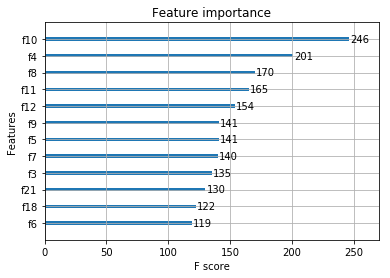

In [11]:
xgb.plot_importance(model_xgb[0],max_num_features=12)

In [133]:
np.save(f'{PATH}\\AV_Stud_2\\train_67.npy', X_stack_train)
np.save(f'{PATH}\\AV_Stud_2\\test_67.npy', X_stack_test)
np.save(f'{PATH}\\AV_Stud_2\\target.npy', target)

## 9th July Night

In [7]:
X_stack_train = np.load(f'{PATH}\\AV_Stud_2\\train_67.npy')
X_stack_test = np.load(f'{PATH}\\AV_Stud_2\\test_67.npy')
target = np.load(f'{PATH}\\AV_Stud_2\\target.npy')

In [20]:
clf_ada = AdaBoostClassifier(n_estimators=100, learning_rate= 0.05)

In [21]:
clf_ada.fit(X_stack_train, target)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.05, n_estimators=100, random_state=None)

In [51]:
preds = clf_ada.predict_proba(X_stack_test)[:, 1]

In [79]:
submit = make_submission(p_test)
submit.to_csv(f'{PATH}\\AV_Stud_2\\stacked_sklearn_showdown.csv', index=False)
submit.head(2)

,enrollee_id,target
0,16548,0.219328
1,12036,0.026984


In [53]:
stack_test = pd.DataFrame()
stack_train = pd.DataFrame()
log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

In [54]:
 def train_k_fold(x_train, y_train, model=None, x_test=None, folds=7, stratify=None, random_state=1337):

    assert model is not None, "model can't be none, Please pass your model."
    
    if hasattr(x_train, 'columns'):
        columns = x_train.columns.values
        columns_exists = True
    else:
        columns = np.arange(x_train.shape[1])
        columns_exists = False

    x_train = np.asarray(x_train)
    y_train = np.array(y_train)

    if x_test is not None:
        if columns_exists:
            try:
                x_test = x_test[columns]
            except Exception as e:
                print('x_test columns doesn\'t match x_train columns.')
                raise e
        x_test = np.asarray(x_test)

    assert x_train.shape[1] == x_test.shape[1], "x_train and x_test have different numbers of features."

    print('Training {} {}models on training set {} {}'.format(folds, 'stratified ' if stratify is not None else '',
        x_train.shape, 'with test set {}'.format(x_test.shape) if x_test is not None else 'without a test set'))

    if stratify is not None:
        kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
        splits = kf.split(x_train, stratify)
    else:
        kf = KFold(n_splits=folds, shuffle=True, random_state=4242)
        splits = kf.split(x_train)

    p_train = np.zeros_like(y_train, dtype=np.float32)
    ps_test = []
    models = []
    scores = []
    fold_i = 0

    for train_kf, valid_kf in splits:
        
        print('Running fold {}, {} train samples, {} validation samples'.format(fold_i, len(train_kf), len(valid_kf)))
        
        d_train, label_train = x_train[train_kf], y_train[train_kf]
        d_valid, label_valid = x_train[valid_kf], y_train[valid_kf]

        mdl = model.fit(d_train,label_train)
        scores.append(mdl.score(d_valid, label_valid))
        print('Finished training fold {} - running score {} '.format(fold_i, np.mean(scores)))

        # Get predictions from the model 

        if hasattr(mdl,'predict_proba'):
            #print('Using model.predict_proba')
            p_valid = mdl.predict_proba(d_valid)[:,1]
            if x_test is not None:
                p_test = mdl.predict_proba(x_test)[:,1]
        else:
            #print('Using model.predict')
            p_valid = mdl.predict(d_valid)
            if x_test is not None:
                p_test = mdl.predict(x_test)

        p_train[valid_kf] = p_valid

        ps_test.append(p_test)
        models.append(mdl)

        fold_i += 1

    if x_test is not None:
        p_test = np.mean(ps_test, axis=0)

    print('Finished training {} models '.format(folds))

    if x_test is None:
        p_test = None

    return models, p_train, p_test, scores

In [80]:
classifiers = [
#     GradientBoostingClassifier(max_depth=10,subsample=0.8,max_features='auto'),
#     MLPClassifier(alpha=0.01,validation_fraction=0.2),
#     ExtraTreesClassifier(100,max_depth=10,n_jobs=-1,class_weight='balanced_subsample',bootstrap=True,oob_score=True),
#     DecisionTreeClassifier(min_samples_leaf= 3, class_weight ='balanced', max_features=.85, max_leaf_nodes=5, max_depth = 10),
#     RandomForestClassifier(n_estimators=100,max_features=.85,n_jobs=-1,class_weight='balanced'),
#     AdaBoostClassifier(n_estimators=200, learning_rate=0.15),
#     RandomForestClassifier(n_estimators=200,max_features=.85,max_depth=7,n_jobs=-1,class_weight='balanced'),
#     LogisticRegression(class_weight='balanced',max_iter=500, multi_class='ovr', n_jobs=-1)
    model
    ]

# Logging for Visual Comparison ( see above cell)
count = 0
for clf in classifiers:    
    name = clf.__class__.__name__+'{}'.format(count)
    print("="*60, name)

    models, p_train, p_test, scores = train_k_fold(stack_train, target, clf, stack_test, 7, target)
    
#     stack_test[name] = p_test
#     stack_train[name] = p_train
    
#     print("Accuracy: {:.4%}".format(np.mean(scores)))
    
#     log_entry = pd.DataFrame([[name, np.mean(scores)*100]], columns=log_cols)
#     log = log.append(log_entry)
    
#     del models, p_train, p_test, scores
    
    count += 1
    print(gc.collect())
    submit = make_submission(p_test)
    submit.to_csv(f'{PATH}\\AV_Stud_2\\stacked_sklearn_showdown.csv', index=False)
    submit.head(2)

============================================================ CatBoostClassifier0
Training 7 stratified models on training set (18359, 10) with test set (15021, 10)
Running fold 0, 15735 train samples, 2624 validation samples
0:	learn: 0.6481851	total: 64.9ms	remaining: 1m 6s
1:	learn: 0.6094124	total: 121ms	remaining: 1m 1s
2:	learn: 0.5760035	total: 187ms	remaining: 1m 3s
3:	learn: 0.5472214	total: 241ms	remaining: 1m 1s
4:	learn: 0.5225398	total: 294ms	remaining: 59.7s
5:	learn: 0.5012622	total: 347ms	remaining: 58.7s
6:	learn: 0.4828539	total: 400ms	remaining: 57.9s
7:	learn: 0.4668394	total: 454ms	remaining: 57.5s
8:	learn: 0.4533647	total: 508ms	remaining: 57.1s
9:	learn: 0.4415375	total: 562ms	remaining: 56.8s
10:	learn: 0.4314057	total: 615ms	remaining: 56.4s
11:	learn: 0.4226526	total: 667ms	remaining: 56s
12:	learn: 0.4151155	total: 722ms	remaining: 56s
13:	learn: 0.4084843	total: 778ms	remaining: 55.9s
14:	learn: 0.4026703	total: 830ms	remaining: 55.6s
15:	learn: 0.3976716	to

157:	learn: 0.3371609	total: 8.82s	remaining: 48.1s
158:	learn: 0.3370312	total: 8.87s	remaining: 48s
159:	learn: 0.3369015	total: 8.93s	remaining: 48s
160:	learn: 0.3367198	total: 8.98s	remaining: 47.9s
161:	learn: 0.3365333	total: 9.04s	remaining: 47.9s
162:	learn: 0.3363206	total: 9.09s	remaining: 47.8s
163:	learn: 0.3361117	total: 9.14s	remaining: 47.7s
164:	learn: 0.3358580	total: 9.2s	remaining: 47.7s
165:	learn: 0.3356329	total: 9.26s	remaining: 47.6s
166:	learn: 0.3353967	total: 9.32s	remaining: 47.6s
167:	learn: 0.3349739	total: 9.38s	remaining: 47.6s
168:	learn: 0.3346338	total: 9.43s	remaining: 47.5s
169:	learn: 0.3343537	total: 9.48s	remaining: 47.4s
170:	learn: 0.3340408	total: 9.53s	remaining: 47.3s
171:	learn: 0.3338820	total: 9.59s	remaining: 47.3s
172:	learn: 0.3337164	total: 9.64s	remaining: 47.2s
173:	learn: 0.3335392	total: 9.7s	remaining: 47.2s
174:	learn: 0.3332552	total: 9.76s	remaining: 47.1s
175:	learn: 0.3331193	total: 9.82s	remaining: 47.1s
176:	learn: 0.3329

316:	learn: 0.3057716	total: 17.5s	remaining: 38.8s
317:	learn: 0.3056827	total: 17.6s	remaining: 38.8s
318:	learn: 0.3055169	total: 17.6s	remaining: 38.7s
319:	learn: 0.3051994	total: 17.7s	remaining: 38.6s
320:	learn: 0.3051130	total: 17.7s	remaining: 38.6s
321:	learn: 0.3049854	total: 17.8s	remaining: 38.5s
322:	learn: 0.3048600	total: 17.8s	remaining: 38.5s
323:	learn: 0.3047321	total: 17.9s	remaining: 38.4s
324:	learn: 0.3046151	total: 17.9s	remaining: 38.4s
325:	learn: 0.3044832	total: 18s	remaining: 38.3s
326:	learn: 0.3043078	total: 18.1s	remaining: 38.3s
327:	learn: 0.3041846	total: 18.1s	remaining: 38.2s
328:	learn: 0.3040707	total: 18.2s	remaining: 38.1s
329:	learn: 0.3039529	total: 18.2s	remaining: 38.1s
330:	learn: 0.3038453	total: 18.3s	remaining: 38s
331:	learn: 0.3037811	total: 18.3s	remaining: 37.9s
332:	learn: 0.3037244	total: 18.4s	remaining: 37.9s
333:	learn: 0.3036491	total: 18.4s	remaining: 37.8s
334:	learn: 0.3033735	total: 18.5s	remaining: 37.8s
335:	learn: 0.30

475:	learn: 0.2855398	total: 26s	remaining: 29.7s
476:	learn: 0.2854337	total: 26.1s	remaining: 29.7s
477:	learn: 0.2852846	total: 26.1s	remaining: 29.6s
478:	learn: 0.2851864	total: 26.2s	remaining: 29.6s
479:	learn: 0.2850513	total: 26.2s	remaining: 29.5s
480:	learn: 0.2849473	total: 26.3s	remaining: 29.5s
481:	learn: 0.2848752	total: 26.4s	remaining: 29.4s
482:	learn: 0.2847960	total: 26.4s	remaining: 29.4s
483:	learn: 0.2847650	total: 26.5s	remaining: 29.3s
484:	learn: 0.2846974	total: 26.6s	remaining: 29.3s
485:	learn: 0.2846002	total: 26.6s	remaining: 29.3s
486:	learn: 0.2844568	total: 26.7s	remaining: 29.2s
487:	learn: 0.2843299	total: 26.7s	remaining: 29.1s
488:	learn: 0.2842862	total: 26.8s	remaining: 29.1s
489:	learn: 0.2841858	total: 26.8s	remaining: 29s
490:	learn: 0.2841266	total: 26.9s	remaining: 29s
491:	learn: 0.2840770	total: 27s	remaining: 28.9s
492:	learn: 0.2840619	total: 27s	remaining: 28.9s
493:	learn: 0.2839793	total: 27.1s	remaining: 28.8s
494:	learn: 0.2838372	

634:	learn: 0.2719105	total: 34.5s	remaining: 20.9s
635:	learn: 0.2718100	total: 34.6s	remaining: 20.9s
636:	learn: 0.2716541	total: 34.6s	remaining: 20.8s
637:	learn: 0.2715708	total: 34.7s	remaining: 20.8s
638:	learn: 0.2714615	total: 34.7s	remaining: 20.7s
639:	learn: 0.2714590	total: 34.8s	remaining: 20.7s
640:	learn: 0.2714068	total: 34.8s	remaining: 20.6s
641:	learn: 0.2713250	total: 34.9s	remaining: 20.5s
642:	learn: 0.2713188	total: 34.9s	remaining: 20.5s
643:	learn: 0.2712659	total: 35s	remaining: 20.4s
644:	learn: 0.2712095	total: 35s	remaining: 20.4s
645:	learn: 0.2710945	total: 35.1s	remaining: 20.3s
646:	learn: 0.2710698	total: 35.1s	remaining: 20.3s
647:	learn: 0.2709912	total: 35.2s	remaining: 20.2s
648:	learn: 0.2709555	total: 35.2s	remaining: 20.1s
649:	learn: 0.2709171	total: 35.3s	remaining: 20.1s
650:	learn: 0.2708217	total: 35.3s	remaining: 20s
651:	learn: 0.2706892	total: 35.4s	remaining: 20s
652:	learn: 0.2706406	total: 35.5s	remaining: 19.9s
653:	learn: 0.270567

793:	learn: 0.2622420	total: 42.3s	remaining: 12s
794:	learn: 0.2621679	total: 42.3s	remaining: 12s
795:	learn: 0.2620849	total: 42.4s	remaining: 11.9s
796:	learn: 0.2619969	total: 42.4s	remaining: 11.9s
797:	learn: 0.2618774	total: 42.5s	remaining: 11.8s
798:	learn: 0.2618159	total: 42.5s	remaining: 11.8s
799:	learn: 0.2616985	total: 42.6s	remaining: 11.7s
800:	learn: 0.2616727	total: 42.6s	remaining: 11.6s
801:	learn: 0.2616032	total: 42.7s	remaining: 11.6s
802:	learn: 0.2615703	total: 42.7s	remaining: 11.5s
803:	learn: 0.2614134	total: 42.8s	remaining: 11.5s
804:	learn: 0.2613408	total: 42.8s	remaining: 11.4s
805:	learn: 0.2613175	total: 42.8s	remaining: 11.4s
806:	learn: 0.2612249	total: 42.9s	remaining: 11.3s
807:	learn: 0.2612015	total: 42.9s	remaining: 11.3s
808:	learn: 0.2611345	total: 43s	remaining: 11.2s
809:	learn: 0.2611146	total: 43s	remaining: 11.2s
810:	learn: 0.2610883	total: 43.1s	remaining: 11.1s
811:	learn: 0.2610357	total: 43.1s	remaining: 11.1s
812:	learn: 0.261000

952:	learn: 0.2544085	total: 50.1s	remaining: 3.52s
953:	learn: 0.2543340	total: 50.2s	remaining: 3.47s
954:	learn: 0.2543016	total: 50.2s	remaining: 3.42s
955:	learn: 0.2543015	total: 50.3s	remaining: 3.37s
956:	learn: 0.2543014	total: 50.3s	remaining: 3.31s
957:	learn: 0.2542572	total: 50.4s	remaining: 3.26s
958:	learn: 0.2542535	total: 50.4s	remaining: 3.21s
959:	learn: 0.2540336	total: 50.5s	remaining: 3.15s
960:	learn: 0.2539736	total: 50.6s	remaining: 3.1s
961:	learn: 0.2539653	total: 50.6s	remaining: 3.05s
962:	learn: 0.2539187	total: 50.7s	remaining: 3s
963:	learn: 0.2537790	total: 50.7s	remaining: 2.95s
964:	learn: 0.2537401	total: 50.8s	remaining: 2.9s
965:	learn: 0.2537317	total: 50.9s	remaining: 2.84s
966:	learn: 0.2537315	total: 50.9s	remaining: 2.79s
967:	learn: 0.2537315	total: 50.9s	remaining: 2.74s
968:	learn: 0.2536145	total: 51s	remaining: 2.68s
969:	learn: 0.2535526	total: 51.1s	remaining: 2.63s
970:	learn: 0.2535194	total: 51.1s	remaining: 2.58s
971:	learn: 0.25351

90:	learn: 0.3511216	total: 5.2s	remaining: 53s
91:	learn: 0.3509246	total: 5.27s	remaining: 53.1s
92:	learn: 0.3504499	total: 5.34s	remaining: 53.2s
93:	learn: 0.3503694	total: 5.4s	remaining: 53.2s
94:	learn: 0.3501770	total: 5.46s	remaining: 53.2s
95:	learn: 0.3498937	total: 5.52s	remaining: 53.2s
96:	learn: 0.3495112	total: 5.59s	remaining: 53.2s
97:	learn: 0.3492977	total: 5.65s	remaining: 53.1s
98:	learn: 0.3491640	total: 5.71s	remaining: 53.1s
99:	learn: 0.3488566	total: 5.79s	remaining: 53.2s
100:	learn: 0.3487467	total: 5.86s	remaining: 53.3s
101:	learn: 0.3483938	total: 5.94s	remaining: 53.4s
102:	learn: 0.3482012	total: 6.01s	remaining: 53.5s
103:	learn: 0.3480828	total: 6.08s	remaining: 53.5s
104:	learn: 0.3479604	total: 6.14s	remaining: 53.5s
105:	learn: 0.3476520	total: 6.21s	remaining: 53.6s
106:	learn: 0.3474388	total: 6.28s	remaining: 53.6s
107:	learn: 0.3471969	total: 6.34s	remaining: 53.5s
108:	learn: 0.3469173	total: 6.4s	remaining: 53.5s
109:	learn: 0.3467255	total

249:	learn: 0.3186070	total: 14.8s	remaining: 45.7s
250:	learn: 0.3184932	total: 14.9s	remaining: 45.6s
251:	learn: 0.3182387	total: 14.9s	remaining: 45.5s
252:	learn: 0.3181320	total: 15s	remaining: 45.4s
253:	learn: 0.3179208	total: 15s	remaining: 45.4s
254:	learn: 0.3177568	total: 15.1s	remaining: 45.3s
255:	learn: 0.3174356	total: 15.1s	remaining: 45.2s
256:	learn: 0.3173493	total: 15.2s	remaining: 45.1s
257:	learn: 0.3171460	total: 15.3s	remaining: 45s
258:	learn: 0.3169996	total: 15.3s	remaining: 45s
259:	learn: 0.3168511	total: 15.4s	remaining: 44.9s
260:	learn: 0.3166329	total: 15.4s	remaining: 44.8s
261:	learn: 0.3163478	total: 15.5s	remaining: 44.7s
262:	learn: 0.3160592	total: 15.5s	remaining: 44.6s
263:	learn: 0.3158390	total: 15.6s	remaining: 44.6s
264:	learn: 0.3157322	total: 15.6s	remaining: 44.5s
265:	learn: 0.3154858	total: 15.7s	remaining: 44.4s
266:	learn: 0.3152950	total: 15.7s	remaining: 44.4s
267:	learn: 0.3150677	total: 15.8s	remaining: 44.3s
268:	learn: 0.314925

408:	learn: 0.2923658	total: 24s	remaining: 35.9s
409:	learn: 0.2923052	total: 24.1s	remaining: 35.8s
410:	learn: 0.2920815	total: 24.1s	remaining: 35.7s
411:	learn: 0.2920157	total: 24.1s	remaining: 35.6s
412:	learn: 0.2918921	total: 24.2s	remaining: 35.6s
413:	learn: 0.2917421	total: 24.2s	remaining: 35.5s
414:	learn: 0.2916178	total: 24.3s	remaining: 35.4s
415:	learn: 0.2914174	total: 24.3s	remaining: 35.3s
416:	learn: 0.2912539	total: 24.4s	remaining: 35.3s
417:	learn: 0.2911301	total: 24.4s	remaining: 35.2s
418:	learn: 0.2910848	total: 24.5s	remaining: 35.1s
419:	learn: 0.2909676	total: 24.6s	remaining: 35.1s
420:	learn: 0.2907931	total: 24.6s	remaining: 35s
421:	learn: 0.2906038	total: 24.7s	remaining: 35s
422:	learn: 0.2904863	total: 24.7s	remaining: 34.9s
423:	learn: 0.2904627	total: 24.8s	remaining: 34.9s
424:	learn: 0.2903527	total: 24.9s	remaining: 34.8s
425:	learn: 0.2903228	total: 24.9s	remaining: 34.7s
426:	learn: 0.2902891	total: 25s	remaining: 34.7s
427:	learn: 0.290102

567:	learn: 0.2741974	total: 33.1s	remaining: 26.4s
568:	learn: 0.2741063	total: 33.2s	remaining: 26.3s
569:	learn: 0.2740522	total: 33.2s	remaining: 26.2s
570:	learn: 0.2739113	total: 33.3s	remaining: 26.2s
571:	learn: 0.2738544	total: 33.4s	remaining: 26.1s
572:	learn: 0.2738119	total: 33.4s	remaining: 26.1s
573:	learn: 0.2737698	total: 33.5s	remaining: 26s
574:	learn: 0.2737424	total: 33.5s	remaining: 25.9s
575:	learn: 0.2736590	total: 33.6s	remaining: 25.9s
576:	learn: 0.2735589	total: 33.6s	remaining: 25.8s
577:	learn: 0.2734517	total: 33.7s	remaining: 25.7s
578:	learn: 0.2734516	total: 33.7s	remaining: 25.6s
579:	learn: 0.2733980	total: 33.7s	remaining: 25.6s
580:	learn: 0.2733037	total: 33.8s	remaining: 25.5s
581:	learn: 0.2732480	total: 33.8s	remaining: 25.5s
582:	learn: 0.2730859	total: 33.9s	remaining: 25.4s
583:	learn: 0.2730155	total: 34s	remaining: 25.4s
584:	learn: 0.2728653	total: 34s	remaining: 25.3s
585:	learn: 0.2728137	total: 34.1s	remaining: 25.2s
586:	learn: 0.2726

726:	learn: 0.2614615	total: 42.3s	remaining: 17.1s
727:	learn: 0.2614076	total: 42.4s	remaining: 17s
728:	learn: 0.2613401	total: 42.4s	remaining: 16.9s
729:	learn: 0.2612865	total: 42.5s	remaining: 16.9s
730:	learn: 0.2612306	total: 42.6s	remaining: 16.8s
731:	learn: 0.2611581	total: 42.7s	remaining: 16.8s
732:	learn: 0.2610897	total: 42.7s	remaining: 16.7s
733:	learn: 0.2610230	total: 42.8s	remaining: 16.7s
734:	learn: 0.2610158	total: 42.8s	remaining: 16.6s
735:	learn: 0.2609876	total: 42.9s	remaining: 16.5s
736:	learn: 0.2609665	total: 42.9s	remaining: 16.5s
737:	learn: 0.2609597	total: 42.9s	remaining: 16.4s
738:	learn: 0.2608845	total: 43s	remaining: 16.4s
739:	learn: 0.2608089	total: 43.1s	remaining: 16.3s
740:	learn: 0.2607610	total: 43.1s	remaining: 16.2s
741:	learn: 0.2606750	total: 43.2s	remaining: 16.2s
742:	learn: 0.2606459	total: 43.2s	remaining: 16.1s
743:	learn: 0.2605477	total: 43.3s	remaining: 16s
744:	learn: 0.2604986	total: 43.3s	remaining: 16s
745:	learn: 0.260443

885:	learn: 0.2515654	total: 51.2s	remaining: 7.74s
886:	learn: 0.2514138	total: 51.3s	remaining: 7.68s
887:	learn: 0.2513197	total: 51.3s	remaining: 7.63s
888:	learn: 0.2512626	total: 51.4s	remaining: 7.57s
889:	learn: 0.2511992	total: 51.4s	remaining: 7.51s
890:	learn: 0.2510398	total: 51.5s	remaining: 7.45s
891:	learn: 0.2510069	total: 51.5s	remaining: 7.39s
892:	learn: 0.2509333	total: 51.6s	remaining: 7.33s
893:	learn: 0.2508858	total: 51.6s	remaining: 7.28s
894:	learn: 0.2508107	total: 51.7s	remaining: 7.22s
895:	learn: 0.2507662	total: 51.7s	remaining: 7.16s
896:	learn: 0.2507001	total: 51.8s	remaining: 7.1s
897:	learn: 0.2506254	total: 51.8s	remaining: 7.04s
898:	learn: 0.2505740	total: 51.9s	remaining: 6.98s
899:	learn: 0.2505739	total: 51.9s	remaining: 6.92s
900:	learn: 0.2505605	total: 52s	remaining: 6.86s
901:	learn: 0.2505497	total: 52s	remaining: 6.8s
902:	learn: 0.2504432	total: 52.1s	remaining: 6.75s
903:	learn: 0.2503726	total: 52.1s	remaining: 6.69s
904:	learn: 0.2503

22:	learn: 0.3778814	total: 1.15s	remaining: 50s
23:	learn: 0.3761041	total: 1.21s	remaining: 50.1s
24:	learn: 0.3744568	total: 1.26s	remaining: 50s
25:	learn: 0.3730224	total: 1.3s	remaining: 49.9s
26:	learn: 0.3718382	total: 1.35s	remaining: 49.8s
27:	learn: 0.3708757	total: 1.4s	remaining: 49.7s
28:	learn: 0.3699658	total: 1.45s	remaining: 49.6s
29:	learn: 0.3690812	total: 1.5s	remaining: 49.5s
30:	learn: 0.3682451	total: 1.55s	remaining: 49.4s
31:	learn: 0.3675831	total: 1.6s	remaining: 49.3s
32:	learn: 0.3668546	total: 1.65s	remaining: 49.2s
33:	learn: 0.3662519	total: 1.69s	remaining: 49.1s
34:	learn: 0.3657247	total: 1.74s	remaining: 49.1s
35:	learn: 0.3651335	total: 1.79s	remaining: 49s
36:	learn: 0.3647235	total: 1.84s	remaining: 49s
37:	learn: 0.3640634	total: 1.89s	remaining: 48.9s
38:	learn: 0.3636877	total: 1.94s	remaining: 48.9s
39:	learn: 0.3633547	total: 1.99s	remaining: 48.8s
40:	learn: 0.3630124	total: 2.04s	remaining: 48.8s
41:	learn: 0.3626953	total: 2.09s	remaining

183:	learn: 0.3329456	total: 9.96s	remaining: 45.2s
184:	learn: 0.3327553	total: 10s	remaining: 45.2s
185:	learn: 0.3326117	total: 10.1s	remaining: 45.2s
186:	learn: 0.3324414	total: 10.1s	remaining: 45.2s
187:	learn: 0.3322558	total: 10.2s	remaining: 45.2s
188:	learn: 0.3319765	total: 10.3s	remaining: 45.1s
189:	learn: 0.3314847	total: 10.3s	remaining: 45.1s
190:	learn: 0.3313214	total: 10.4s	remaining: 45.1s
191:	learn: 0.3310848	total: 10.4s	remaining: 45.1s
192:	learn: 0.3308304	total: 10.5s	remaining: 45s
193:	learn: 0.3305541	total: 10.6s	remaining: 45s
194:	learn: 0.3304004	total: 10.6s	remaining: 45s
195:	learn: 0.3302799	total: 10.7s	remaining: 44.9s
196:	learn: 0.3301382	total: 10.8s	remaining: 44.9s
197:	learn: 0.3300179	total: 10.8s	remaining: 44.9s
198:	learn: 0.3298201	total: 10.9s	remaining: 44.9s
199:	learn: 0.3295737	total: 10.9s	remaining: 44.8s
200:	learn: 0.3294912	total: 11s	remaining: 44.8s
201:	learn: 0.3291321	total: 11.1s	remaining: 44.8s
202:	learn: 0.3288611	

342:	learn: 0.3033058	total: 19s	remaining: 37.5s
343:	learn: 0.3032284	total: 19.1s	remaining: 37.5s
344:	learn: 0.3031543	total: 19.1s	remaining: 37.4s
345:	learn: 0.3030150	total: 19.2s	remaining: 37.4s
346:	learn: 0.3029199	total: 19.3s	remaining: 37.4s
347:	learn: 0.3027823	total: 19.3s	remaining: 37.3s
348:	learn: 0.3026935	total: 19.4s	remaining: 37.3s
349:	learn: 0.3025397	total: 19.4s	remaining: 37.2s
350:	learn: 0.3024336	total: 19.5s	remaining: 37.2s
351:	learn: 0.3022840	total: 19.6s	remaining: 37.2s
352:	learn: 0.3020636	total: 19.6s	remaining: 37.1s
353:	learn: 0.3019880	total: 19.7s	remaining: 37.1s
354:	learn: 0.3019104	total: 19.8s	remaining: 37s
355:	learn: 0.3017769	total: 19.8s	remaining: 36.9s
356:	learn: 0.3016662	total: 19.9s	remaining: 36.9s
357:	learn: 0.3015621	total: 19.9s	remaining: 36.8s
358:	learn: 0.3014520	total: 20s	remaining: 36.8s
359:	learn: 0.3013714	total: 20s	remaining: 36.7s
360:	learn: 0.3012657	total: 20.1s	remaining: 36.6s
361:	learn: 0.301156

501:	learn: 0.2824989	total: 27.9s	remaining: 28.7s
502:	learn: 0.2822416	total: 27.9s	remaining: 28.7s
503:	learn: 0.2821558	total: 28s	remaining: 28.6s
504:	learn: 0.2819828	total: 28s	remaining: 28.6s
505:	learn: 0.2818967	total: 28.1s	remaining: 28.5s
506:	learn: 0.2818376	total: 28.1s	remaining: 28.4s
507:	learn: 0.2817356	total: 28.2s	remaining: 28.4s
508:	learn: 0.2815994	total: 28.2s	remaining: 28.3s
509:	learn: 0.2815504	total: 28.3s	remaining: 28.3s
510:	learn: 0.2814219	total: 28.3s	remaining: 28.2s
511:	learn: 0.2812196	total: 28.3s	remaining: 28.1s
512:	learn: 0.2810038	total: 28.4s	remaining: 28.1s
513:	learn: 0.2809129	total: 28.4s	remaining: 28s
514:	learn: 0.2808562	total: 28.5s	remaining: 27.9s
515:	learn: 0.2807211	total: 28.5s	remaining: 27.9s
516:	learn: 0.2806391	total: 28.6s	remaining: 27.8s
517:	learn: 0.2805116	total: 28.6s	remaining: 27.8s
518:	learn: 0.2804327	total: 28.7s	remaining: 27.7s
519:	learn: 0.2802648	total: 28.8s	remaining: 27.6s
520:	learn: 0.2802

660:	learn: 0.2673128	total: 36.3s	remaining: 19.7s
661:	learn: 0.2672589	total: 36.3s	remaining: 19.6s
662:	learn: 0.2671985	total: 36.4s	remaining: 19.6s
663:	learn: 0.2671108	total: 36.4s	remaining: 19.5s
664:	learn: 0.2670797	total: 36.5s	remaining: 19.5s
665:	learn: 0.2670396	total: 36.5s	remaining: 19.4s
666:	learn: 0.2669870	total: 36.6s	remaining: 19.3s
667:	learn: 0.2668029	total: 36.6s	remaining: 19.3s
668:	learn: 0.2667099	total: 36.7s	remaining: 19.2s
669:	learn: 0.2666716	total: 36.7s	remaining: 19.2s
670:	learn: 0.2665178	total: 36.8s	remaining: 19.1s
671:	learn: 0.2664886	total: 36.8s	remaining: 19.1s
672:	learn: 0.2664478	total: 36.9s	remaining: 19s
673:	learn: 0.2664071	total: 36.9s	remaining: 18.9s
674:	learn: 0.2663887	total: 37s	remaining: 18.9s
675:	learn: 0.2663886	total: 37s	remaining: 18.8s
676:	learn: 0.2662919	total: 37.1s	remaining: 18.8s
677:	learn: 0.2662140	total: 37.1s	remaining: 18.7s
678:	learn: 0.2661186	total: 37.2s	remaining: 18.7s
679:	learn: 0.2660

819:	learn: 0.2558958	total: 44.8s	remaining: 10.9s
820:	learn: 0.2558319	total: 44.9s	remaining: 10.9s
821:	learn: 0.2557421	total: 44.9s	remaining: 10.8s
822:	learn: 0.2556910	total: 45s	remaining: 10.8s
823:	learn: 0.2556356	total: 45.1s	remaining: 10.7s
824:	learn: 0.2556070	total: 45.1s	remaining: 10.7s
825:	learn: 0.2555104	total: 45.2s	remaining: 10.6s
826:	learn: 0.2554886	total: 45.3s	remaining: 10.6s
827:	learn: 0.2554146	total: 45.3s	remaining: 10.5s
828:	learn: 0.2552900	total: 45.4s	remaining: 10.5s
829:	learn: 0.2551272	total: 45.4s	remaining: 10.4s
830:	learn: 0.2550693	total: 45.5s	remaining: 10.3s
831:	learn: 0.2549761	total: 45.6s	remaining: 10.3s
832:	learn: 0.2549754	total: 45.6s	remaining: 10.2s
833:	learn: 0.2549131	total: 45.6s	remaining: 10.2s
834:	learn: 0.2548160	total: 45.7s	remaining: 10.1s
835:	learn: 0.2547605	total: 45.8s	remaining: 10.1s
836:	learn: 0.2545440	total: 45.8s	remaining: 10s
837:	learn: 0.2544404	total: 45.9s	remaining: 9.97s
838:	learn: 0.25

978:	learn: 0.2469264	total: 53.9s	remaining: 2.26s
979:	learn: 0.2468869	total: 54s	remaining: 2.2s
980:	learn: 0.2468676	total: 54.1s	remaining: 2.15s
981:	learn: 0.2467108	total: 54.1s	remaining: 2.09s
982:	learn: 0.2466369	total: 54.2s	remaining: 2.04s
983:	learn: 0.2465730	total: 54.2s	remaining: 1.98s
984:	learn: 0.2464943	total: 54.3s	remaining: 1.93s
985:	learn: 0.2464720	total: 54.3s	remaining: 1.87s
986:	learn: 0.2464507	total: 54.4s	remaining: 1.82s
987:	learn: 0.2464485	total: 54.4s	remaining: 1.76s
988:	learn: 0.2463844	total: 54.5s	remaining: 1.71s
989:	learn: 0.2463844	total: 54.5s	remaining: 1.65s
990:	learn: 0.2463843	total: 54.5s	remaining: 1.59s
991:	learn: 0.2463842	total: 54.5s	remaining: 1.54s
992:	learn: 0.2463745	total: 54.6s	remaining: 1.48s
993:	learn: 0.2463523	total: 54.6s	remaining: 1.43s
994:	learn: 0.2463432	total: 54.7s	remaining: 1.37s
995:	learn: 0.2463274	total: 54.7s	remaining: 1.32s
996:	learn: 0.2463274	total: 54.7s	remaining: 1.26s
997:	learn: 0.2

116:	learn: 0.3432827	total: 6.91s	remaining: 53.4s
117:	learn: 0.3431261	total: 6.96s	remaining: 53.2s
118:	learn: 0.3429061	total: 7.02s	remaining: 53.1s
119:	learn: 0.3425668	total: 7.07s	remaining: 53s
120:	learn: 0.3423282	total: 7.12s	remaining: 52.9s
121:	learn: 0.3421069	total: 7.17s	remaining: 52.8s
122:	learn: 0.3417590	total: 7.22s	remaining: 52.6s
123:	learn: 0.3415691	total: 7.27s	remaining: 52.5s
124:	learn: 0.3412517	total: 7.32s	remaining: 52.4s
125:	learn: 0.3410968	total: 7.37s	remaining: 52.3s
126:	learn: 0.3408442	total: 7.42s	remaining: 52.2s
127:	learn: 0.3407545	total: 7.47s	remaining: 52.1s
128:	learn: 0.3405341	total: 7.52s	remaining: 51.9s
129:	learn: 0.3403128	total: 7.57s	remaining: 51.8s
130:	learn: 0.3401885	total: 7.62s	remaining: 51.7s
131:	learn: 0.3401148	total: 7.67s	remaining: 51.6s
132:	learn: 0.3399784	total: 7.72s	remaining: 51.5s
133:	learn: 0.3398441	total: 7.77s	remaining: 51.4s
134:	learn: 0.3397258	total: 7.82s	remaining: 51.3s
135:	learn: 0.

275:	learn: 0.3122683	total: 15.6s	remaining: 42s
276:	learn: 0.3121708	total: 15.7s	remaining: 42s
277:	learn: 0.3120485	total: 15.7s	remaining: 41.9s
278:	learn: 0.3118692	total: 15.7s	remaining: 41.8s
279:	learn: 0.3117601	total: 15.8s	remaining: 41.7s
280:	learn: 0.3116280	total: 15.8s	remaining: 41.7s
281:	learn: 0.3114421	total: 15.9s	remaining: 41.6s
282:	learn: 0.3112355	total: 15.9s	remaining: 41.5s
283:	learn: 0.3110946	total: 16s	remaining: 41.4s
284:	learn: 0.3109252	total: 16s	remaining: 41.4s
285:	learn: 0.3107455	total: 16.1s	remaining: 41.3s
286:	learn: 0.3105983	total: 16.1s	remaining: 41.2s
287:	learn: 0.3104840	total: 16.2s	remaining: 41.2s
288:	learn: 0.3103893	total: 16.2s	remaining: 41.1s
289:	learn: 0.3100791	total: 16.3s	remaining: 41.1s
290:	learn: 0.3099120	total: 16.4s	remaining: 41s
291:	learn: 0.3097026	total: 16.5s	remaining: 41s
292:	learn: 0.3096262	total: 16.5s	remaining: 41s
293:	learn: 0.3095402	total: 16.6s	remaining: 40.9s
294:	learn: 0.3093566	tota

434:	learn: 0.2902778	total: 24.4s	remaining: 32.9s
435:	learn: 0.2901955	total: 24.5s	remaining: 32.8s
436:	learn: 0.2900951	total: 24.6s	remaining: 32.8s
437:	learn: 0.2900005	total: 24.6s	remaining: 32.7s
438:	learn: 0.2899107	total: 24.7s	remaining: 32.7s
439:	learn: 0.2898611	total: 24.7s	remaining: 32.6s
440:	learn: 0.2897926	total: 24.8s	remaining: 32.6s
441:	learn: 0.2895331	total: 24.9s	remaining: 32.5s
442:	learn: 0.2894337	total: 24.9s	remaining: 32.5s
443:	learn: 0.2892898	total: 25s	remaining: 32.4s
444:	learn: 0.2891699	total: 25.1s	remaining: 32.4s
445:	learn: 0.2890656	total: 25.1s	remaining: 32.3s
446:	learn: 0.2889233	total: 25.2s	remaining: 32.3s
447:	learn: 0.2888660	total: 25.2s	remaining: 32.2s
448:	learn: 0.2887120	total: 25.3s	remaining: 32.2s
449:	learn: 0.2884824	total: 25.4s	remaining: 32.1s
450:	learn: 0.2883929	total: 25.4s	remaining: 32.1s
451:	learn: 0.2882376	total: 25.5s	remaining: 32s
452:	learn: 0.2880558	total: 25.5s	remaining: 32s
453:	learn: 0.2879

593:	learn: 0.2744696	total: 33.3s	remaining: 23.9s
594:	learn: 0.2744025	total: 33.3s	remaining: 23.8s
595:	learn: 0.2743159	total: 33.4s	remaining: 23.8s
596:	learn: 0.2741609	total: 33.5s	remaining: 23.7s
597:	learn: 0.2740955	total: 33.5s	remaining: 23.6s
598:	learn: 0.2739866	total: 33.6s	remaining: 23.6s
599:	learn: 0.2739332	total: 33.6s	remaining: 23.5s
600:	learn: 0.2738516	total: 33.7s	remaining: 23.5s
601:	learn: 0.2738515	total: 33.7s	remaining: 23.4s
602:	learn: 0.2737313	total: 33.7s	remaining: 23.3s
603:	learn: 0.2736533	total: 33.8s	remaining: 23.3s
604:	learn: 0.2736356	total: 33.8s	remaining: 23.2s
605:	learn: 0.2735852	total: 33.9s	remaining: 23.1s
606:	learn: 0.2734694	total: 33.9s	remaining: 23.1s
607:	learn: 0.2733906	total: 34s	remaining: 23s
608:	learn: 0.2733436	total: 34s	remaining: 23s
609:	learn: 0.2732879	total: 34.1s	remaining: 22.9s
610:	learn: 0.2732472	total: 34.1s	remaining: 22.8s
611:	learn: 0.2731323	total: 34.2s	remaining: 22.8s
612:	learn: 0.273124

752:	learn: 0.2640870	total: 41.3s	remaining: 14.6s
753:	learn: 0.2640618	total: 41.3s	remaining: 14.6s
754:	learn: 0.2639038	total: 41.4s	remaining: 14.5s
755:	learn: 0.2638588	total: 41.4s	remaining: 14.5s
756:	learn: 0.2637254	total: 41.5s	remaining: 14.4s
757:	learn: 0.2636816	total: 41.5s	remaining: 14.3s
758:	learn: 0.2636398	total: 41.6s	remaining: 14.3s
759:	learn: 0.2635846	total: 41.6s	remaining: 14.2s
760:	learn: 0.2634900	total: 41.7s	remaining: 14.2s
761:	learn: 0.2634896	total: 41.7s	remaining: 14.1s
762:	learn: 0.2633983	total: 41.7s	remaining: 14.1s
763:	learn: 0.2632643	total: 41.8s	remaining: 14s
764:	learn: 0.2632114	total: 41.8s	remaining: 13.9s
765:	learn: 0.2630653	total: 41.9s	remaining: 13.9s
766:	learn: 0.2630653	total: 41.9s	remaining: 13.8s
767:	learn: 0.2630651	total: 41.9s	remaining: 13.8s
768:	learn: 0.2629962	total: 42s	remaining: 13.7s
769:	learn: 0.2628784	total: 42s	remaining: 13.6s
770:	learn: 0.2628019	total: 42.1s	remaining: 13.6s
771:	learn: 0.2628

911:	learn: 0.2555276	total: 49.3s	remaining: 5.84s
912:	learn: 0.2554413	total: 49.4s	remaining: 5.79s
913:	learn: 0.2553981	total: 49.4s	remaining: 5.73s
914:	learn: 0.2553896	total: 49.5s	remaining: 5.68s
915:	learn: 0.2553472	total: 49.5s	remaining: 5.62s
916:	learn: 0.2552869	total: 49.6s	remaining: 5.57s
917:	learn: 0.2552801	total: 49.6s	remaining: 5.51s
918:	learn: 0.2552775	total: 49.7s	remaining: 5.46s
919:	learn: 0.2552085	total: 49.7s	remaining: 5.4s
920:	learn: 0.2551511	total: 49.8s	remaining: 5.35s
921:	learn: 0.2551511	total: 49.8s	remaining: 5.29s
922:	learn: 0.2550817	total: 49.8s	remaining: 5.24s
923:	learn: 0.2549750	total: 49.9s	remaining: 5.18s
924:	learn: 0.2549077	total: 49.9s	remaining: 5.13s
925:	learn: 0.2548680	total: 50s	remaining: 5.07s
926:	learn: 0.2548426	total: 50s	remaining: 5.02s
927:	learn: 0.2548210	total: 50.1s	remaining: 4.97s
928:	learn: 0.2548210	total: 50.1s	remaining: 4.91s
929:	learn: 0.2547645	total: 50.2s	remaining: 4.85s
930:	learn: 0.254

48:	learn: 0.3594516	total: 2.49s	remaining: 49.4s
49:	learn: 0.3592884	total: 2.54s	remaining: 49.3s
50:	learn: 0.3590327	total: 2.59s	remaining: 49.3s
51:	learn: 0.3585475	total: 2.65s	remaining: 49.3s
52:	learn: 0.3583696	total: 2.7s	remaining: 49.2s
53:	learn: 0.3581232	total: 2.75s	remaining: 49.1s
54:	learn: 0.3580069	total: 2.79s	remaining: 49s
55:	learn: 0.3578146	total: 2.84s	remaining: 49s
56:	learn: 0.3575721	total: 2.89s	remaining: 48.9s
57:	learn: 0.3572914	total: 2.94s	remaining: 48.8s
58:	learn: 0.3571273	total: 2.99s	remaining: 48.7s
59:	learn: 0.3569437	total: 3.04s	remaining: 48.7s
60:	learn: 0.3567281	total: 3.09s	remaining: 48.6s
61:	learn: 0.3563993	total: 3.14s	remaining: 48.5s
62:	learn: 0.3561634	total: 3.19s	remaining: 48.5s
63:	learn: 0.3557982	total: 3.24s	remaining: 48.4s
64:	learn: 0.3554549	total: 3.29s	remaining: 48.4s
65:	learn: 0.3551955	total: 3.34s	remaining: 48.3s
66:	learn: 0.3550695	total: 3.4s	remaining: 48.3s
67:	learn: 0.3548334	total: 3.46s	rem

209:	learn: 0.3277214	total: 11.3s	remaining: 43.8s
210:	learn: 0.3275542	total: 11.4s	remaining: 43.7s
211:	learn: 0.3274526	total: 11.5s	remaining: 43.7s
212:	learn: 0.3272362	total: 11.5s	remaining: 43.7s
213:	learn: 0.3271557	total: 11.6s	remaining: 43.6s
214:	learn: 0.3270216	total: 11.6s	remaining: 43.6s
215:	learn: 0.3269048	total: 11.7s	remaining: 43.6s
216:	learn: 0.3266966	total: 11.8s	remaining: 43.6s
217:	learn: 0.3265706	total: 11.8s	remaining: 43.5s
218:	learn: 0.3263149	total: 11.9s	remaining: 43.5s
219:	learn: 0.3262435	total: 12s	remaining: 43.5s
220:	learn: 0.3261473	total: 12s	remaining: 43.5s
221:	learn: 0.3259821	total: 12.1s	remaining: 43.4s
222:	learn: 0.3257229	total: 12.1s	remaining: 43.4s
223:	learn: 0.3256129	total: 12.2s	remaining: 43.4s
224:	learn: 0.3252286	total: 12.3s	remaining: 43.3s
225:	learn: 0.3250575	total: 12.3s	remaining: 43.3s
226:	learn: 0.3248916	total: 12.4s	remaining: 43.3s
227:	learn: 0.3247729	total: 12.4s	remaining: 43.2s
228:	learn: 0.32

368:	learn: 0.3035756	total: 20.4s	remaining: 36.1s
369:	learn: 0.3034993	total: 20.5s	remaining: 36s
370:	learn: 0.3034583	total: 20.5s	remaining: 35.9s
371:	learn: 0.3033005	total: 20.6s	remaining: 35.9s
372:	learn: 0.3031095	total: 20.6s	remaining: 35.8s
373:	learn: 0.3029441	total: 20.7s	remaining: 35.7s
374:	learn: 0.3029322	total: 20.7s	remaining: 35.7s
375:	learn: 0.3028340	total: 20.8s	remaining: 35.6s
376:	learn: 0.3027373	total: 20.8s	remaining: 35.5s
377:	learn: 0.3026378	total: 20.9s	remaining: 35.5s
378:	learn: 0.3025651	total: 20.9s	remaining: 35.4s
379:	learn: 0.3025648	total: 21s	remaining: 35.3s
380:	learn: 0.3024876	total: 21s	remaining: 35.2s
381:	learn: 0.3024048	total: 21.1s	remaining: 35.2s
382:	learn: 0.3022822	total: 21.1s	remaining: 35.1s
383:	learn: 0.3021848	total: 21.2s	remaining: 35s
384:	learn: 0.3020555	total: 21.2s	remaining: 35s
385:	learn: 0.3019252	total: 21.3s	remaining: 34.9s
386:	learn: 0.3016979	total: 21.3s	remaining: 34.9s
387:	learn: 0.3015959	

527:	learn: 0.2880710	total: 28.8s	remaining: 26.9s
528:	learn: 0.2879431	total: 28.9s	remaining: 26.8s
529:	learn: 0.2878437	total: 28.9s	remaining: 26.8s
530:	learn: 0.2876613	total: 29s	remaining: 26.7s
531:	learn: 0.2876093	total: 29s	remaining: 26.6s
532:	learn: 0.2876089	total: 29.1s	remaining: 26.6s
533:	learn: 0.2874741	total: 29.1s	remaining: 26.5s
534:	learn: 0.2873655	total: 29.2s	remaining: 26.4s
535:	learn: 0.2872885	total: 29.2s	remaining: 26.4s
536:	learn: 0.2872700	total: 29.3s	remaining: 26.3s
537:	learn: 0.2872481	total: 29.3s	remaining: 26.3s
538:	learn: 0.2871252	total: 29.4s	remaining: 26.2s
539:	learn: 0.2869622	total: 29.4s	remaining: 26.1s
540:	learn: 0.2868589	total: 29.5s	remaining: 26.1s
541:	learn: 0.2868088	total: 29.5s	remaining: 26s
542:	learn: 0.2866163	total: 29.6s	remaining: 26s
543:	learn: 0.2864727	total: 29.6s	remaining: 25.9s
544:	learn: 0.2864460	total: 29.7s	remaining: 25.9s
545:	learn: 0.2863698	total: 29.7s	remaining: 25.8s
546:	learn: 0.286238

686:	learn: 0.2770407	total: 37.4s	remaining: 18.1s
687:	learn: 0.2769424	total: 37.4s	remaining: 18.1s
688:	learn: 0.2768675	total: 37.5s	remaining: 18s
689:	learn: 0.2767963	total: 37.5s	remaining: 17.9s
690:	learn: 0.2767929	total: 37.6s	remaining: 17.9s
691:	learn: 0.2767479	total: 37.6s	remaining: 17.8s
692:	learn: 0.2767457	total: 37.7s	remaining: 17.8s
693:	learn: 0.2766955	total: 37.7s	remaining: 17.7s
694:	learn: 0.2766345	total: 37.8s	remaining: 17.7s
695:	learn: 0.2766029	total: 37.9s	remaining: 17.6s
696:	learn: 0.2766026	total: 37.9s	remaining: 17.6s
697:	learn: 0.2766012	total: 38s	remaining: 17.5s
698:	learn: 0.2764918	total: 38s	remaining: 17.5s
699:	learn: 0.2762661	total: 38.1s	remaining: 17.4s
700:	learn: 0.2762057	total: 38.2s	remaining: 17.4s
701:	learn: 0.2762056	total: 38.2s	remaining: 17.3s
702:	learn: 0.2761672	total: 38.3s	remaining: 17.3s
703:	learn: 0.2761670	total: 38.3s	remaining: 17.2s
704:	learn: 0.2761658	total: 38.4s	remaining: 17.1s
705:	learn: 0.2760

845:	learn: 0.2682792	total: 46s	remaining: 9.46s
846:	learn: 0.2682790	total: 46s	remaining: 9.4s
847:	learn: 0.2682175	total: 46.1s	remaining: 9.35s
848:	learn: 0.2682175	total: 46.1s	remaining: 9.29s
849:	learn: 0.2681579	total: 46.2s	remaining: 9.24s
850:	learn: 0.2681576	total: 46.2s	remaining: 9.18s
851:	learn: 0.2681410	total: 46.3s	remaining: 9.12s
852:	learn: 0.2681405	total: 46.3s	remaining: 9.07s
853:	learn: 0.2681405	total: 46.4s	remaining: 9.01s
854:	learn: 0.2681052	total: 46.4s	remaining: 8.96s
855:	learn: 0.2679178	total: 46.5s	remaining: 8.91s
856:	learn: 0.2678980	total: 46.6s	remaining: 8.86s
857:	learn: 0.2678946	total: 46.6s	remaining: 8.8s
858:	learn: 0.2678164	total: 46.7s	remaining: 8.75s
859:	learn: 0.2677994	total: 46.7s	remaining: 8.7s
860:	learn: 0.2677553	total: 46.8s	remaining: 8.64s
861:	learn: 0.2677452	total: 46.9s	remaining: 8.59s
862:	learn: 0.2677181	total: 46.9s	remaining: 8.54s
863:	learn: 0.2676579	total: 47s	remaining: 8.48s
864:	learn: 0.2675826

1004:	learn: 0.2607976	total: 54.5s	remaining: 813ms
1005:	learn: 0.2607614	total: 54.5s	remaining: 759ms
1006:	learn: 0.2607062	total: 54.6s	remaining: 705ms
1007:	learn: 0.2606853	total: 54.6s	remaining: 650ms
1008:	learn: 0.2606685	total: 54.7s	remaining: 596ms
1009:	learn: 0.2606338	total: 54.7s	remaining: 542ms
1010:	learn: 0.2606337	total: 54.8s	remaining: 488ms
1011:	learn: 0.2605958	total: 54.8s	remaining: 433ms
1012:	learn: 0.2605943	total: 54.9s	remaining: 379ms
1013:	learn: 0.2605864	total: 54.9s	remaining: 325ms
1014:	learn: 0.2605464	total: 55s	remaining: 271ms
1015:	learn: 0.2605442	total: 55s	remaining: 216ms
1016:	learn: 0.2605005	total: 55s	remaining: 162ms
1017:	learn: 0.2602531	total: 55.1s	remaining: 108ms
1018:	learn: 0.2601655	total: 55.2s	remaining: 54.1ms
1019:	learn: 0.2601193	total: 55.2s	remaining: 0us
Finished training fold 4 - running score 0.8630581621767414 
Running fold 5, 15737 train samples, 2622 validation samples
0:	learn: 0.6482718	total: 53.9ms	rem

143:	learn: 0.3392760	total: 7.77s	remaining: 47.3s
144:	learn: 0.3391016	total: 7.82s	remaining: 47.2s
145:	learn: 0.3389362	total: 7.87s	remaining: 47.1s
146:	learn: 0.3386436	total: 7.92s	remaining: 47s
147:	learn: 0.3385101	total: 7.97s	remaining: 46.9s
148:	learn: 0.3383451	total: 8.02s	remaining: 46.9s
149:	learn: 0.3380400	total: 8.07s	remaining: 46.8s
150:	learn: 0.3377415	total: 8.12s	remaining: 46.7s
151:	learn: 0.3376129	total: 8.18s	remaining: 46.7s
152:	learn: 0.3374775	total: 8.22s	remaining: 46.6s
153:	learn: 0.3373225	total: 8.27s	remaining: 46.5s
154:	learn: 0.3372495	total: 8.32s	remaining: 46.4s
155:	learn: 0.3370354	total: 8.37s	remaining: 46.4s
156:	learn: 0.3368430	total: 8.42s	remaining: 46.3s
157:	learn: 0.3365160	total: 8.47s	remaining: 46.2s
158:	learn: 0.3363116	total: 8.52s	remaining: 46.2s
159:	learn: 0.3360203	total: 8.57s	remaining: 46.1s
160:	learn: 0.3357807	total: 8.62s	remaining: 46s
161:	learn: 0.3355712	total: 8.67s	remaining: 45.9s
162:	learn: 0.33

302:	learn: 0.3097962	total: 16.4s	remaining: 38.8s
303:	learn: 0.3095339	total: 16.4s	remaining: 38.7s
304:	learn: 0.3094575	total: 16.5s	remaining: 38.6s
305:	learn: 0.3093944	total: 16.5s	remaining: 38.6s
306:	learn: 0.3091779	total: 16.6s	remaining: 38.5s
307:	learn: 0.3090713	total: 16.7s	remaining: 38.5s
308:	learn: 0.3089081	total: 16.7s	remaining: 38.5s
309:	learn: 0.3087526	total: 16.8s	remaining: 38.4s
310:	learn: 0.3086238	total: 16.8s	remaining: 38.4s
311:	learn: 0.3085069	total: 16.9s	remaining: 38.4s
312:	learn: 0.3084043	total: 17s	remaining: 38.3s
313:	learn: 0.3081256	total: 17s	remaining: 38.3s
314:	learn: 0.3079874	total: 17.1s	remaining: 38.2s
315:	learn: 0.3078293	total: 17.1s	remaining: 38.2s
316:	learn: 0.3076862	total: 17.2s	remaining: 38.1s
317:	learn: 0.3075440	total: 17.3s	remaining: 38.1s
318:	learn: 0.3074542	total: 17.3s	remaining: 38.1s
319:	learn: 0.3072935	total: 17.4s	remaining: 38s
320:	learn: 0.3072833	total: 17.4s	remaining: 38s
321:	learn: 0.307283

461:	learn: 0.2925299	total: 25s	remaining: 30.2s
462:	learn: 0.2924737	total: 25.1s	remaining: 30.2s
463:	learn: 0.2923829	total: 25.2s	remaining: 30.1s
464:	learn: 0.2923356	total: 25.2s	remaining: 30.1s
465:	learn: 0.2922809	total: 25.3s	remaining: 30s
466:	learn: 0.2922442	total: 25.3s	remaining: 30s
467:	learn: 0.2921134	total: 25.4s	remaining: 30s
468:	learn: 0.2919696	total: 25.5s	remaining: 29.9s
469:	learn: 0.2917798	total: 25.5s	remaining: 29.9s
470:	learn: 0.2916264	total: 25.6s	remaining: 29.8s
471:	learn: 0.2915325	total: 25.6s	remaining: 29.8s
472:	learn: 0.2913645	total: 25.7s	remaining: 29.7s
473:	learn: 0.2913427	total: 25.8s	remaining: 29.7s
474:	learn: 0.2911994	total: 25.8s	remaining: 29.6s
475:	learn: 0.2909259	total: 25.9s	remaining: 29.6s
476:	learn: 0.2907077	total: 25.9s	remaining: 29.5s
477:	learn: 0.2906400	total: 26s	remaining: 29.5s
478:	learn: 0.2905587	total: 26.1s	remaining: 29.4s
479:	learn: 0.2905140	total: 26.1s	remaining: 29.4s
480:	learn: 0.2904201	

620:	learn: 0.2778384	total: 34.1s	remaining: 21.9s
621:	learn: 0.2777914	total: 34.2s	remaining: 21.9s
622:	learn: 0.2776481	total: 34.2s	remaining: 21.8s
623:	learn: 0.2775044	total: 34.3s	remaining: 21.8s
624:	learn: 0.2773526	total: 34.3s	remaining: 21.7s
625:	learn: 0.2773110	total: 34.4s	remaining: 21.6s
626:	learn: 0.2771156	total: 34.4s	remaining: 21.6s
627:	learn: 0.2769634	total: 34.5s	remaining: 21.5s
628:	learn: 0.2769248	total: 34.6s	remaining: 21.5s
629:	learn: 0.2767609	total: 34.6s	remaining: 21.4s
630:	learn: 0.2766469	total: 34.7s	remaining: 21.4s
631:	learn: 0.2764234	total: 34.7s	remaining: 21.3s
632:	learn: 0.2763402	total: 34.8s	remaining: 21.3s
633:	learn: 0.2762574	total: 34.8s	remaining: 21.2s
634:	learn: 0.2761337	total: 34.9s	remaining: 21.2s
635:	learn: 0.2759482	total: 34.9s	remaining: 21.1s
636:	learn: 0.2757898	total: 35s	remaining: 21s
637:	learn: 0.2757408	total: 35s	remaining: 21s
638:	learn: 0.2756726	total: 35.1s	remaining: 20.9s
639:	learn: 0.275617

779:	learn: 0.2647102	total: 43.1s	remaining: 13.3s
780:	learn: 0.2644487	total: 43.2s	remaining: 13.2s
781:	learn: 0.2644098	total: 43.2s	remaining: 13.2s
782:	learn: 0.2643421	total: 43.3s	remaining: 13.1s
783:	learn: 0.2643125	total: 43.3s	remaining: 13s
784:	learn: 0.2642970	total: 43.4s	remaining: 13s
785:	learn: 0.2642691	total: 43.4s	remaining: 12.9s
786:	learn: 0.2642659	total: 43.5s	remaining: 12.9s
787:	learn: 0.2641477	total: 43.5s	remaining: 12.8s
788:	learn: 0.2640597	total: 43.6s	remaining: 12.8s
789:	learn: 0.2639935	total: 43.6s	remaining: 12.7s
790:	learn: 0.2639095	total: 43.7s	remaining: 12.6s
791:	learn: 0.2638795	total: 43.7s	remaining: 12.6s
792:	learn: 0.2638349	total: 43.8s	remaining: 12.5s
793:	learn: 0.2637079	total: 43.8s	remaining: 12.5s
794:	learn: 0.2637035	total: 43.9s	remaining: 12.4s
795:	learn: 0.2635223	total: 43.9s	remaining: 12.4s
796:	learn: 0.2634472	total: 44s	remaining: 12.3s
797:	learn: 0.2633916	total: 44.1s	remaining: 12.3s
798:	learn: 0.2633

938:	learn: 0.2558745	total: 51.9s	remaining: 4.48s
939:	learn: 0.2557954	total: 52s	remaining: 4.42s
940:	learn: 0.2557950	total: 52s	remaining: 4.37s
941:	learn: 0.2556620	total: 52.1s	remaining: 4.31s
942:	learn: 0.2556487	total: 52.2s	remaining: 4.26s
943:	learn: 0.2556221	total: 52.2s	remaining: 4.2s
944:	learn: 0.2555649	total: 52.3s	remaining: 4.15s
945:	learn: 0.2554653	total: 52.3s	remaining: 4.09s
946:	learn: 0.2553960	total: 52.4s	remaining: 4.04s
947:	learn: 0.2553766	total: 52.5s	remaining: 3.98s
948:	learn: 0.2553761	total: 52.5s	remaining: 3.93s
949:	learn: 0.2553031	total: 52.6s	remaining: 3.88s
950:	learn: 0.2552980	total: 52.7s	remaining: 3.82s
951:	learn: 0.2552850	total: 52.7s	remaining: 3.77s
952:	learn: 0.2552179	total: 52.8s	remaining: 3.71s
953:	learn: 0.2552018	total: 52.8s	remaining: 3.65s
954:	learn: 0.2551817	total: 52.9s	remaining: 3.6s
955:	learn: 0.2551817	total: 52.9s	remaining: 3.54s
956:	learn: 0.2551698	total: 53s	remaining: 3.49s
957:	learn: 0.255082

76:	learn: 0.3538652	total: 4.11s	remaining: 50.3s
77:	learn: 0.3537278	total: 4.17s	remaining: 50.4s
78:	learn: 0.3534631	total: 4.24s	remaining: 50.5s
79:	learn: 0.3532699	total: 4.3s	remaining: 50.6s
80:	learn: 0.3530560	total: 4.37s	remaining: 50.7s
81:	learn: 0.3527576	total: 4.44s	remaining: 50.8s
82:	learn: 0.3526016	total: 4.51s	remaining: 50.9s
83:	learn: 0.3523887	total: 4.58s	remaining: 51.1s
84:	learn: 0.3522113	total: 4.65s	remaining: 51.1s
85:	learn: 0.3520651	total: 4.71s	remaining: 51.2s
86:	learn: 0.3519327	total: 4.79s	remaining: 51.3s
87:	learn: 0.3518148	total: 4.86s	remaining: 51.4s
88:	learn: 0.3516816	total: 4.93s	remaining: 51.6s
89:	learn: 0.3514482	total: 5s	remaining: 51.7s
90:	learn: 0.3511707	total: 5.06s	remaining: 51.7s
91:	learn: 0.3508912	total: 5.13s	remaining: 51.8s
92:	learn: 0.3506149	total: 5.2s	remaining: 51.8s
93:	learn: 0.3504823	total: 5.26s	remaining: 51.8s
94:	learn: 0.3502713	total: 5.32s	remaining: 51.8s
95:	learn: 0.3500618	total: 5.38s	re

235:	learn: 0.3229468	total: 13.3s	remaining: 44s
236:	learn: 0.3225792	total: 13.3s	remaining: 44s
237:	learn: 0.3224473	total: 13.4s	remaining: 43.9s
238:	learn: 0.3221504	total: 13.4s	remaining: 43.9s
239:	learn: 0.3219699	total: 13.5s	remaining: 43.9s
240:	learn: 0.3218506	total: 13.6s	remaining: 43.8s
241:	learn: 0.3216938	total: 13.6s	remaining: 43.8s
242:	learn: 0.3213202	total: 13.7s	remaining: 43.7s
243:	learn: 0.3211284	total: 13.7s	remaining: 43.7s
244:	learn: 0.3209729	total: 13.8s	remaining: 43.7s
245:	learn: 0.3208830	total: 13.9s	remaining: 43.6s
246:	learn: 0.3207881	total: 13.9s	remaining: 43.6s
247:	learn: 0.3204611	total: 14s	remaining: 43.5s
248:	learn: 0.3202664	total: 14s	remaining: 43.5s
249:	learn: 0.3201836	total: 14.1s	remaining: 43.4s
250:	learn: 0.3199512	total: 14.2s	remaining: 43.4s
251:	learn: 0.3198612	total: 14.2s	remaining: 43.4s
252:	learn: 0.3195557	total: 14.3s	remaining: 43.3s
253:	learn: 0.3194271	total: 14.3s	remaining: 43.3s
254:	learn: 0.319265

394:	learn: 0.2959836	total: 22.7s	remaining: 35.8s
395:	learn: 0.2959269	total: 22.7s	remaining: 35.8s
396:	learn: 0.2954627	total: 22.8s	remaining: 35.7s
397:	learn: 0.2953106	total: 22.8s	remaining: 35.7s
398:	learn: 0.2951070	total: 22.9s	remaining: 35.6s
399:	learn: 0.2950378	total: 22.9s	remaining: 35.5s
400:	learn: 0.2948748	total: 23s	remaining: 35.5s
401:	learn: 0.2948385	total: 23s	remaining: 35.4s
402:	learn: 0.2947233	total: 23.1s	remaining: 35.4s
403:	learn: 0.2945622	total: 23.1s	remaining: 35.3s
404:	learn: 0.2944582	total: 23.2s	remaining: 35.2s
405:	learn: 0.2942913	total: 23.3s	remaining: 35.2s
406:	learn: 0.2941812	total: 23.3s	remaining: 35.1s
407:	learn: 0.2941323	total: 23.4s	remaining: 35s
408:	learn: 0.2940495	total: 23.4s	remaining: 35s
409:	learn: 0.2940122	total: 23.5s	remaining: 34.9s
410:	learn: 0.2937426	total: 23.5s	remaining: 34.8s
411:	learn: 0.2936203	total: 23.6s	remaining: 34.8s
412:	learn: 0.2935031	total: 23.6s	remaining: 34.7s
413:	learn: 0.293408

553:	learn: 0.2767009	total: 31.9s	remaining: 26.8s
554:	learn: 0.2766080	total: 31.9s	remaining: 26.8s
555:	learn: 0.2763747	total: 32s	remaining: 26.7s
556:	learn: 0.2763140	total: 32.1s	remaining: 26.6s
557:	learn: 0.2761266	total: 32.1s	remaining: 26.6s
558:	learn: 0.2760207	total: 32.2s	remaining: 26.5s
559:	learn: 0.2759108	total: 32.2s	remaining: 26.5s
560:	learn: 0.2757483	total: 32.3s	remaining: 26.4s
561:	learn: 0.2755013	total: 32.3s	remaining: 26.4s
562:	learn: 0.2754266	total: 32.4s	remaining: 26.3s
563:	learn: 0.2753152	total: 32.4s	remaining: 26.2s
564:	learn: 0.2752298	total: 32.5s	remaining: 26.2s
565:	learn: 0.2751638	total: 32.5s	remaining: 26.1s
566:	learn: 0.2750934	total: 32.6s	remaining: 26s
567:	learn: 0.2749728	total: 32.6s	remaining: 26s
568:	learn: 0.2748016	total: 32.7s	remaining: 25.9s
569:	learn: 0.2746830	total: 32.7s	remaining: 25.8s
570:	learn: 0.2746530	total: 32.8s	remaining: 25.8s
571:	learn: 0.2745214	total: 32.8s	remaining: 25.7s
572:	learn: 0.2743

712:	learn: 0.2604039	total: 40.9s	remaining: 17.6s
713:	learn: 0.2603416	total: 40.9s	remaining: 17.5s
714:	learn: 0.2602386	total: 41s	remaining: 17.5s
715:	learn: 0.2600764	total: 41.1s	remaining: 17.4s
716:	learn: 0.2599958	total: 41.1s	remaining: 17.4s
717:	learn: 0.2597771	total: 41.2s	remaining: 17.3s
718:	learn: 0.2597572	total: 41.2s	remaining: 17.3s
719:	learn: 0.2596510	total: 41.3s	remaining: 17.2s
720:	learn: 0.2596063	total: 41.4s	remaining: 17.2s
721:	learn: 0.2595767	total: 41.4s	remaining: 17.1s
722:	learn: 0.2594698	total: 41.5s	remaining: 17s
723:	learn: 0.2594150	total: 41.5s	remaining: 17s
724:	learn: 0.2593818	total: 41.6s	remaining: 16.9s
725:	learn: 0.2593371	total: 41.7s	remaining: 16.9s
726:	learn: 0.2593078	total: 41.7s	remaining: 16.8s
727:	learn: 0.2592292	total: 41.8s	remaining: 16.8s
728:	learn: 0.2590583	total: 41.9s	remaining: 16.7s
729:	learn: 0.2588513	total: 41.9s	remaining: 16.7s
730:	learn: 0.2587462	total: 42s	remaining: 16.6s
731:	learn: 0.258605

871:	learn: 0.2492186	total: 50.1s	remaining: 8.5s
872:	learn: 0.2491617	total: 50.1s	remaining: 8.44s
873:	learn: 0.2490435	total: 50.2s	remaining: 8.38s
874:	learn: 0.2489518	total: 50.2s	remaining: 8.32s
875:	learn: 0.2488663	total: 50.3s	remaining: 8.27s
876:	learn: 0.2486644	total: 50.3s	remaining: 8.21s
877:	learn: 0.2486257	total: 50.4s	remaining: 8.15s
878:	learn: 0.2483930	total: 50.5s	remaining: 8.09s
879:	learn: 0.2482275	total: 50.5s	remaining: 8.04s
880:	learn: 0.2481654	total: 50.6s	remaining: 7.98s
881:	learn: 0.2481345	total: 50.6s	remaining: 7.92s
882:	learn: 0.2480914	total: 50.7s	remaining: 7.86s
883:	learn: 0.2479906	total: 50.7s	remaining: 7.81s
884:	learn: 0.2479036	total: 50.8s	remaining: 7.75s
885:	learn: 0.2478508	total: 50.9s	remaining: 7.69s
886:	learn: 0.2477200	total: 50.9s	remaining: 7.64s
887:	learn: 0.2476738	total: 51s	remaining: 7.58s
888:	learn: 0.2476586	total: 51s	remaining: 7.52s
889:	learn: 0.2476323	total: 51.1s	remaining: 7.46s
890:	learn: 0.247

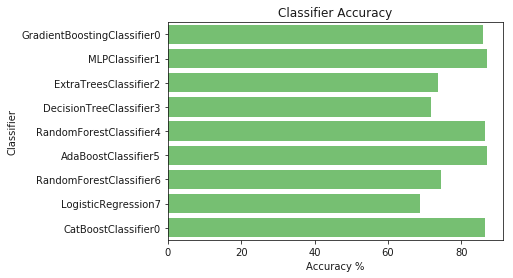

In [72]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color='g')
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy');

In [81]:
stack_train.to_csv(f'{PATH}\\AV_Stud_2\\stack_train.csv', index = False)
stack_test.to_csv(f'{PATH}\\AV_Stud_2\\stack_test.csv', index = False)
log.to_csv(f'{PATH}\\AV_Stud_2\\log.csv', index = False)

In [77]:
model_xgb, p_train, p_test  = mlcrate.xgb.train_kfold(params, X_stack_train, target, X_stack_test\
                                                       , folds = 7,skip_checks = True, stratify=target, print_imp='final')

name = model_xgb[3].__class__.__name__    
stack_test[name] = p_test
stack_train[name] = p_train

In [78]:
_, _, p_test  = mlcrate.xgb.train_kfold(params, stack_train, target, stack_test\
                                                       , folds = 7,skip_checks = True, stratify=target, print_imp='final')

[mlcrate] Training 7 stratified XGBoost models on training set (18359, 10) with test set (15021, 10)
[mlcrate] Running fold 0, 15735 train samples, 2624 validation samples
[0]	train-auc:0.615934	valid-auc:0.607321
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.629118	valid-auc:0.628424
[2]	train-auc:0.630865	valid-auc:0.633996
[3]	train-auc:0.630775	valid-auc:0.63441
[4]	train-auc:0.637561	valid-auc:0.642621
[5]	train-auc:0.644279	valid-auc:0.651041
[6]	train-auc:0.64541	valid-auc:0.652507
[7]	train-auc:0.645342	valid-auc:0.65265
[8]	train-auc:0.645266	valid-auc:0.652513
[9]	train-auc:0.646424	valid-auc:0.651394
[10]	train-auc:0.646405	valid-auc:0.651458
[11]	train-auc:0.646484	valid-auc:0.650984
[12]	train-auc:0.646599	valid-auc:0.650187
[13]	train-auc:0.650218	valid-auc:0.658353
[14]	train-auc:0.650199	valid-auc:0.658422
[15]	train-auc:0.650164	valid-auc:0.658099
[16]	train

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 0 - took 4s - running score 0.674835
[mlcrate] Running fold 1, 15735 train samples, 2624 validation samples
[0]	train-auc:0.628639	valid-auc:0.648939
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.628639	valid-auc:0.648939
[2]	train-auc:0.628639	valid-auc:0.648939
[3]	train-auc:0.639463	valid-auc:0.667051
[4]	train-auc:0.639412	valid-auc:0.666863
[5]	train-auc:0.639371	valid-auc:0.666893
[6]	train-auc:0.639371	valid-auc:0.666893
[7]	train-auc:0.641499	valid-auc:0.67121
[8]	train-auc:0.643775	valid-auc:0.674814
[9]	train-auc:0.645027	valid-auc:0.678509
[10]	train-auc:0.644915	valid-auc:0.678063
[11]	train-auc:0.644915	valid-auc:0.678063
[12]	train-auc:0.644915	valid-auc:0.678063
[13]	train-auc:0.644915	valid-auc:0.678063
[14]	train-auc:0.645869	valid-auc:0.680225
[15]	train-auc:0.647503	valid-auc:0.682732
[16]	train-auc:0.647628	valid-auc:0.682

[73]	train-auc:0.68526	valid-auc:0.686401
[74]	train-auc:0.690386	valid-auc:0.691616
[75]	train-auc:0.690528	valid-auc:0.691865
[76]	train-auc:0.692872	valid-auc:0.690526
[77]	train-auc:0.693314	valid-auc:0.690618
[78]	train-auc:0.693418	valid-auc:0.690218
[79]	train-auc:0.694044	valid-auc:0.692373
[80]	train-auc:0.697428	valid-auc:0.692624
[81]	train-auc:0.697659	valid-auc:0.692701
[82]	train-auc:0.699032	valid-auc:0.693713
[83]	train-auc:0.699857	valid-auc:0.690384
[84]	train-auc:0.70169	valid-auc:0.689506
[85]	train-auc:0.701613	valid-auc:0.689514
[86]	train-auc:0.702895	valid-auc:0.690734
[87]	train-auc:0.703313	valid-auc:0.691062
[88]	train-auc:0.706026	valid-auc:0.691528
[89]	train-auc:0.707897	valid-auc:0.692122
[90]	train-auc:0.709292	valid-auc:0.692582
[91]	train-auc:0.709859	valid-auc:0.693256
[92]	train-auc:0.710284	valid-auc:0.693515
[93]	train-auc:0.710957	valid-auc:0.69355
[94]	train-auc:0.712328	valid-auc:0.69227
[95]	train-auc:0.712417	valid-auc:0.691757
[96]	train-auc:

[122]	train-auc:0.734573	valid-auc:0.646498
[123]	train-auc:0.735018	valid-auc:0.64643
[124]	train-auc:0.736807	valid-auc:0.645798
[125]	train-auc:0.738035	valid-auc:0.646035
[126]	train-auc:0.737997	valid-auc:0.646445
[127]	train-auc:0.737997	valid-auc:0.646445
[128]	train-auc:0.738204	valid-auc:0.646689
[129]	train-auc:0.738694	valid-auc:0.646434
[130]	train-auc:0.739085	valid-auc:0.646662
[131]	train-auc:0.739216	valid-auc:0.646564
[132]	train-auc:0.739827	valid-auc:0.646163
[133]	train-auc:0.740021	valid-auc:0.646069
[134]	train-auc:0.740859	valid-auc:0.646009
[135]	train-auc:0.740859	valid-auc:0.646009
[136]	train-auc:0.741043	valid-auc:0.646156
[137]	train-auc:0.741453	valid-auc:0.646114
[138]	train-auc:0.74163	valid-auc:0.646048
[139]	train-auc:0.741588	valid-auc:0.645949
[140]	train-auc:0.742042	valid-auc:0.646274
[141]	train-auc:0.742638	valid-auc:0.645959
[142]	train-auc:0.742638	valid-auc:0.645959
[143]	train-auc:0.742718	valid-auc:0.645943
[144]	train-auc:0.742822	valid-auc

[51]	train-auc:0.678543	valid-auc:0.663993
[52]	train-auc:0.678578	valid-auc:0.663808
[53]	train-auc:0.679907	valid-auc:0.664191
[54]	train-auc:0.681655	valid-auc:0.663462
[55]	train-auc:0.681946	valid-auc:0.663586
[56]	train-auc:0.683393	valid-auc:0.662815
[57]	train-auc:0.68359	valid-auc:0.662785
[58]	train-auc:0.683917	valid-auc:0.662772
[59]	train-auc:0.684414	valid-auc:0.662819
[60]	train-auc:0.685414	valid-auc:0.662735
[61]	train-auc:0.685482	valid-auc:0.663068
[62]	train-auc:0.68593	valid-auc:0.662735
[63]	train-auc:0.685937	valid-auc:0.66269
[64]	train-auc:0.686155	valid-auc:0.662836
[65]	train-auc:0.686682	valid-auc:0.662639
[66]	train-auc:0.686765	valid-auc:0.662589
[67]	train-auc:0.687211	valid-auc:0.662367
[68]	train-auc:0.687615	valid-auc:0.662029
[69]	train-auc:0.687692	valid-auc:0.662047
[70]	train-auc:0.688236	valid-auc:0.662041
[71]	train-auc:0.689988	valid-auc:0.664578
[72]	train-auc:0.693449	valid-auc:0.668186
[73]	train-auc:0.69416	valid-auc:0.668473
[74]	train-auc:

[89]	train-auc:0.71092	valid-auc:0.66769
[90]	train-auc:0.71184	valid-auc:0.668609
[91]	train-auc:0.712747	valid-auc:0.669511
[92]	train-auc:0.714795	valid-auc:0.669148
[93]	train-auc:0.716183	valid-auc:0.667662
[94]	train-auc:0.716141	valid-auc:0.668247
[95]	train-auc:0.716995	valid-auc:0.668816
[96]	train-auc:0.71751	valid-auc:0.668476
[97]	train-auc:0.719129	valid-auc:0.667233
[98]	train-auc:0.721116	valid-auc:0.666451
[99]	train-auc:0.720861	valid-auc:0.666566
[100]	train-auc:0.721689	valid-auc:0.66603
[101]	train-auc:0.72148	valid-auc:0.665846
[102]	train-auc:0.721537	valid-auc:0.666231
[103]	train-auc:0.72163	valid-auc:0.666214
[104]	train-auc:0.722332	valid-auc:0.665586
[105]	train-auc:0.722813	valid-auc:0.66708
[106]	train-auc:0.722742	valid-auc:0.667093
[107]	train-auc:0.72305	valid-auc:0.667213
[108]	train-auc:0.724063	valid-auc:0.667913
[109]	train-auc:0.724749	valid-auc:0.667441
[110]	train-auc:0.725173	valid-auc:0.667706
[111]	train-auc:0.725173	valid-auc:0.667706
[112]	tr